In [294]:
%matplotlib inline
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import datetime as dt
import multiprocessing
import folium
import branca
import branca.colormap as cm
import pylab
import random as rd
import geopandas
import seaborn
import time
import matplotlib.colors as mcolors

from datetime import datetime, date
from shapely.geometry import Point, Polygon, MultiPolygon
from tqdm.notebook import tqdm
from collections import Counter
from folium.plugins import HeatMap
from folium.features import DivIcon
from folium.plugins import HeatMapWithTime

# Single machine progress bar
from dask.diagnostics import ProgressBar

pd.options.display.precision = 2
#pd.set_option('display.max_columns', None)
nbRowsToDisplay = 100
pd.options.display.min_rows = nbRowsToDisplay
pd.options.display.max_rows = nbRowsToDisplay

plt.rcParams["figure.figsize"] = (20,10)

In [295]:
#Define a function to display an heatmap
Cph_Lat = 12.5683
Cph_Long = 55.6761

#Create a gradient map
steps = 20
#color_map=cm.linear.Accent_07.scale(0,1).to_step(steps)
color_map = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=1)
#color_map1 = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=120)

gradient_map={}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

def generateBaseMap(default_location=[Cph_Long, Cph_Lat], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=12,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(base_map)
    return base_map

def plotHeatmap(latitude,longitude,avgDemand):
    
    heatmap = generateBaseMap() #Base map
    #Heat map
    heatmap.add_child(HeatMap(data=np.vstack((latitude, longitude,avgDemand)).T.tolist(), 
                              radius=7, max_zoom=5,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

def plotHeatmapWithTime(data,index):
    
    heatmap = generateBaseMap() #Base map
    
    #Heatmap
    heatmap.add_child(HeatMapWithTime(data, radius=5,index=index,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

In [296]:
def plotHistogram(counts,labels,tit,xlab,ylab,width=0.8):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.bar(labels, counts, width,align='center')
    ax.set_title(tit, fontsize=28)
    ax.set_xlabel(xlab, fontsize=20)
    ax.set_ylabel(ylab, fontsize=20)
    ax.grid(True)
    ax.set_axisbelow(True)

In [297]:
colorList=list(mcolors.CSS4_COLORS.keys())

def addPointsToMap(my_map,latitudes,longitudes,colors,opacity=0.3):
    
    #Add point
    for lat,lon,col in zip(latitudes,longitudes,colors):
        folium.CircleMarker([lat, lon],
                            radius=1,fill=True,color=col,opacity=opacity
                           ).add_to(my_map)
    
    return my_map

In [298]:
#Define a function to display an heatmap
Cph_Lat = 12.5683
Cph_Long = 55.6761

#Create a gradient map
steps = 20
#color_map=cm.linear.Accent_07.scale(0,1).to_step(steps)
color_map = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=1)
#color_map1 = cm.LinearColormap(['blue', 'yellow', 'red'],vmin=0, vmax=120)

gradient_map={}
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

def generateBaseMap(default_location=[Cph_Long, Cph_Lat], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=12,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(base_map)
    return base_map

def plotHeatmap(latitude,longitude,avgDemand):
    
    heatmap = generateBaseMap() #Base map
    #Heat map
    heatmap.add_child(HeatMap(data=np.vstack((latitude, longitude,avgDemand)).T.tolist(), 
                              radius=7, max_zoom=5,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

def plotHeatmapWithTime(data,index,radius=5):
    
    heatmap = generateBaseMap() #Base map
    
    #Heatmap
    heatmap.add_child(HeatMapWithTime(data, radius=radius,index=index,  gradient=gradient_map))
    
    color_map.add_to(heatmap) #Color bar
    
    return heatmap

In [299]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'

# Check that the daily demand is a linear function of the penetration rate

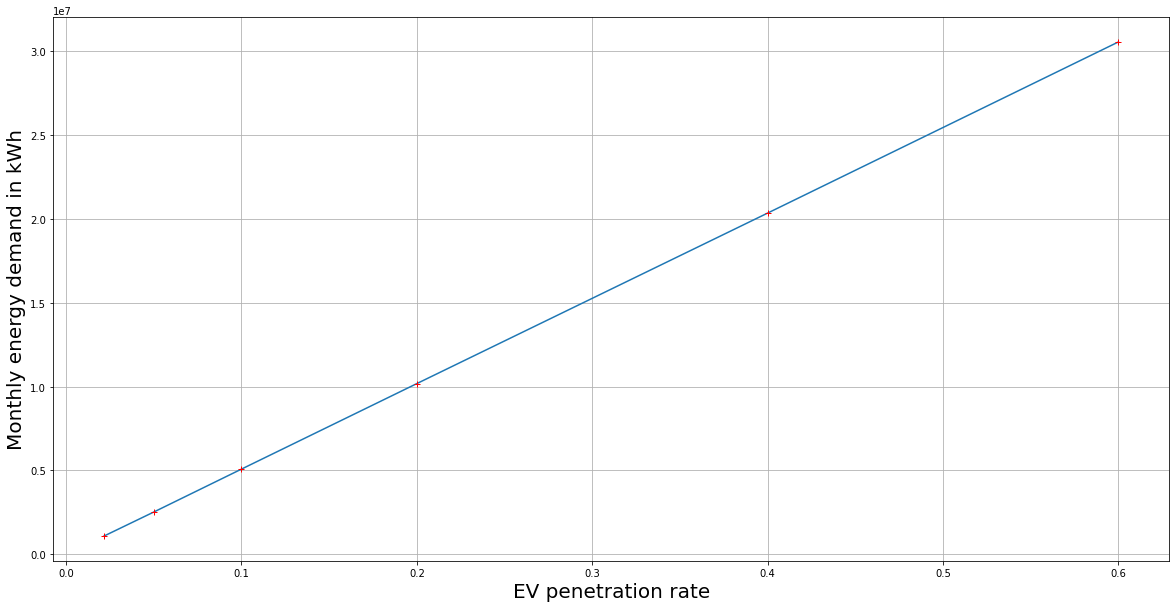

In [285]:
#Get the unmet demand ratios
demand=[]
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]
perimeterInKm=1

for penetrationRate in penetrationRateList:
    df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+
             str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))
    demand.append(df.demand.sum())
    

#Plot the demand function of the penetration rate
plt.plot(penetrationRateList,demand)
plt.plot(penetrationRateList,demand,'r+')
plt.xlabel('EV penetration rate',fontsize=20)
plt.ylabel('Monthly energy demand in kWh',fontsize=20)
plt.grid()


The demand is a linear function of the penetration rate. Thus, it can be concluded that the undersampled or oversampled methods to get the demand for different penetration rates works.

# Evaluate the maximum penetration rate that the current supply can handle

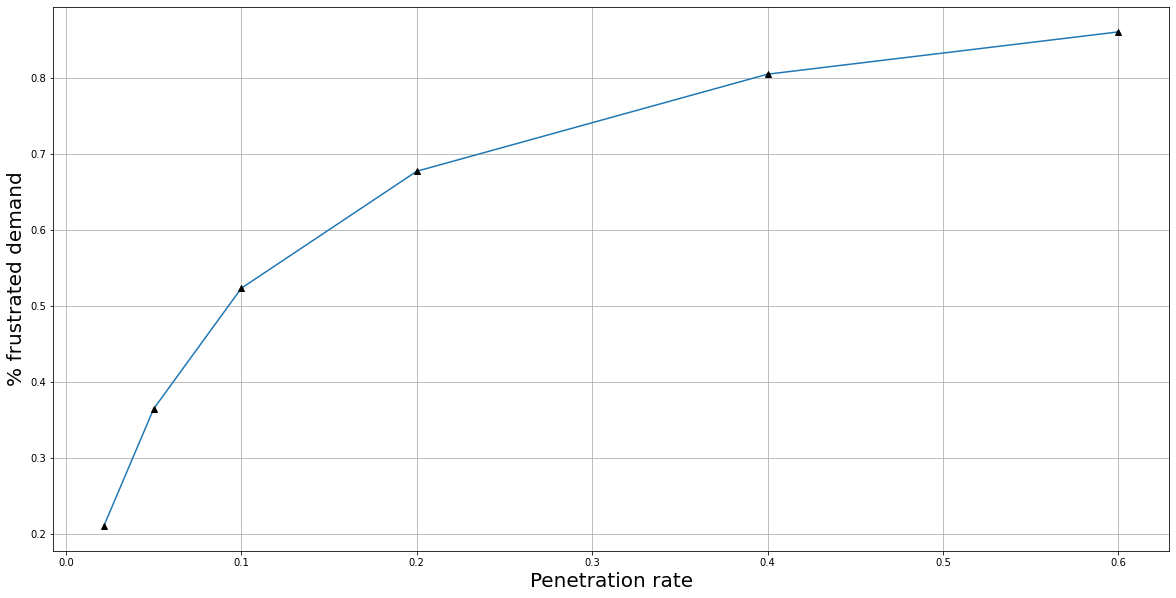

In [286]:
#Get the unmet demand ratios
demand=[]
unservedDemand=[]
unmetDemandRatio=[]
penetrationRateList=[0.0216,0.05,0.1,0.2,0.4,0.6]
perimeterInKm=1

for penetrationRate in penetrationRateList:
    df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+
             str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))
    demand.append(df.demand.sum())
    unservedDemand.append(df.unservedDemand.sum())
    unmetDemandRatio.append(df.unservedDemand.sum()/df.demand.sum())

#Plot the unserved demand function of the penetration rate
plt.plot(penetrationRateList,unmetDemandRatio)
plt.xlabel('Penetration rate',fontsize=20)
plt.ylabel('% frustrated demand',fontsize=20)
plt.grid()
plt.plot(penetrationRateList,unmetDemandRatio,'^',color='black')


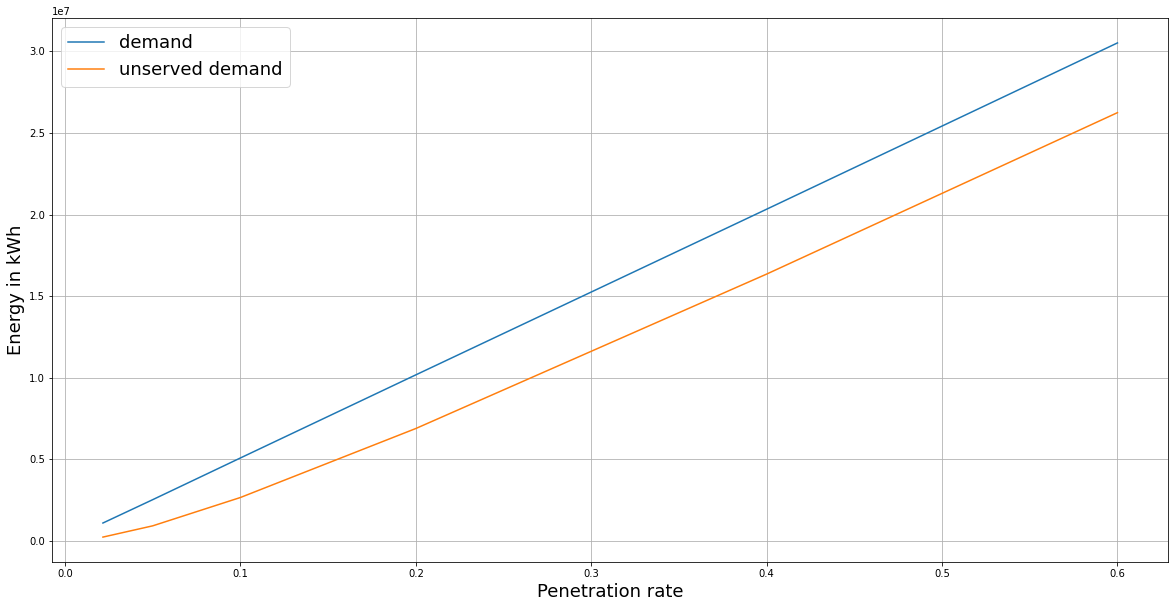

In [287]:
plt.plot(penetrationRateList,demand,label='demand')
plt.plot(penetrationRateList,unservedDemand,label='unserved demand')
plt.legend(fontsize=18)
plt.xlabel('Penetration rate',fontsize=18)
plt.ylabel('Energy in kWh',fontsize=18)
plt.grid()


The demand is increasing faster than the non served demand and that is the reason why the steepness of the unmet demand ratio curve decreases with the penetration rate.

# Check that the charging stations are well assigned

Check that the EV demands are well distributed among charging stations

In [213]:
penetrationRate=0.1
perimeterInKm=1
df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_penetrationRate='+str(penetrationRate)+
            '_PerimeterInKm='+str(perimeterInKm))

df_chargingStations=pd.read_pickle(fileDirectory+"data/Simulation/chargingStations_supply")


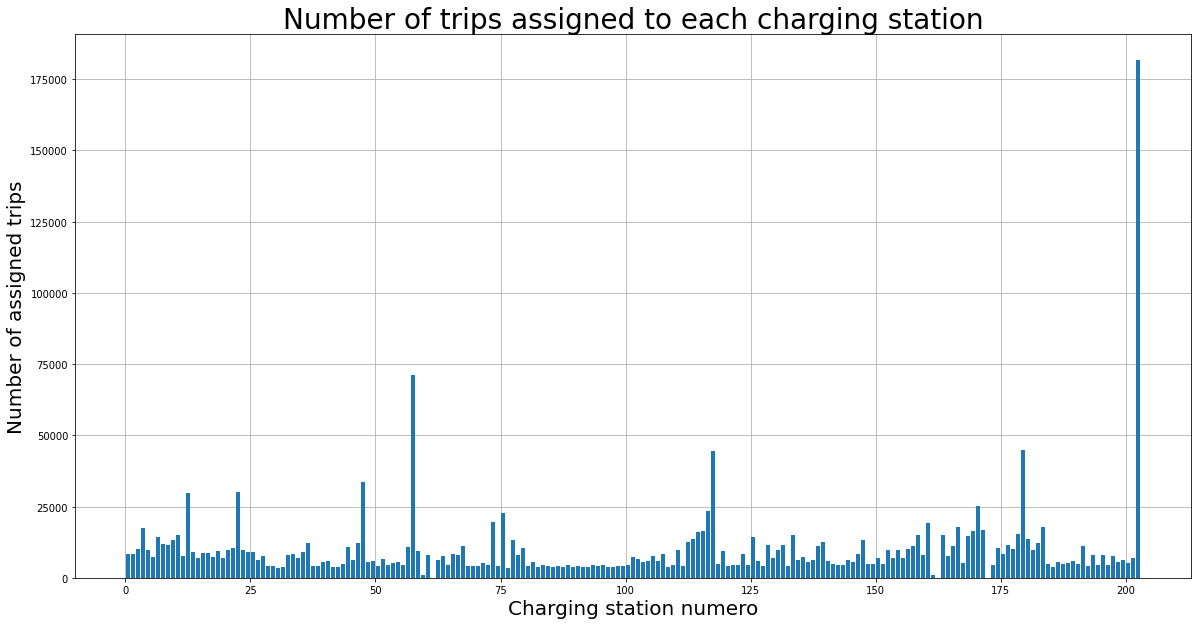

In [214]:
df['tripCount']=1

#Check the cs with the most trips assigned
nbTripsByCS=df[['selectedCS','tripCount']].groupby('selectedCS').sum().sort_values(by='tripCount',ascending=False)

#Add the number of trips assigned to each cs
df_chargingStations=df_chargingStations.merge(nbTripsByCS,how='left',left_index=True,right_index=True)

df_chargingStations['tripCountByOutlet']=df_chargingStations.tripCount/\
    df_chargingStations.nbOutlets.apply(lambda x: np.sum(x))

#Have a look at the number of assigned trips by charging stations 
counts, labels = np.histogram(df.selectedCS,bins=[x -0.5 for x in list(range(1,len(df_chargingStations)+3))])
plotHistogram(counts,labels[:-1],'Number of trips assigned to each charging station','Charging station numero',
'Number of assigned trips',width=0.8)

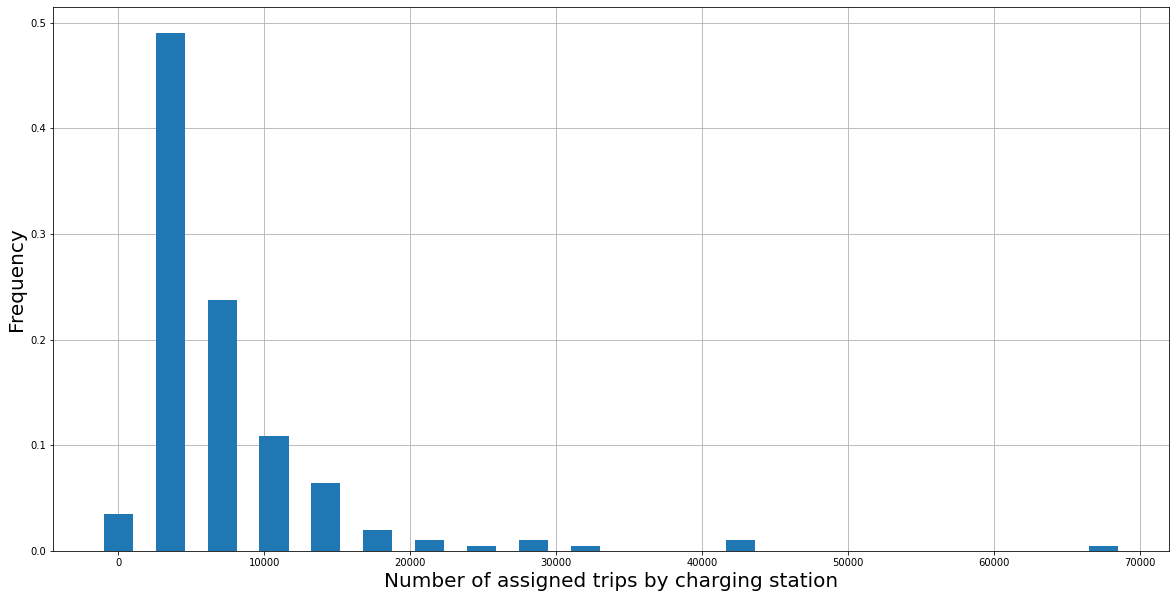

In [210]:
counts1, labels1 = np.histogram(counts[:-1],bins=20)
plotHistogram(counts1/np.sum(counts1),labels1[:-1],'','Number of assigned trips by charging station','Frequency',width=2000)

In [211]:
print("% of end trips that are not in at least a 1 km perimeter from charging stations:",
      np.floor(100*len(df[df.selectedCS==203])/len(df)))

% of end trips that are not in at least a 1 km perimeter from charging stations: 9.0


An important number of trips are not assigned to a charging station. 9% exactly.

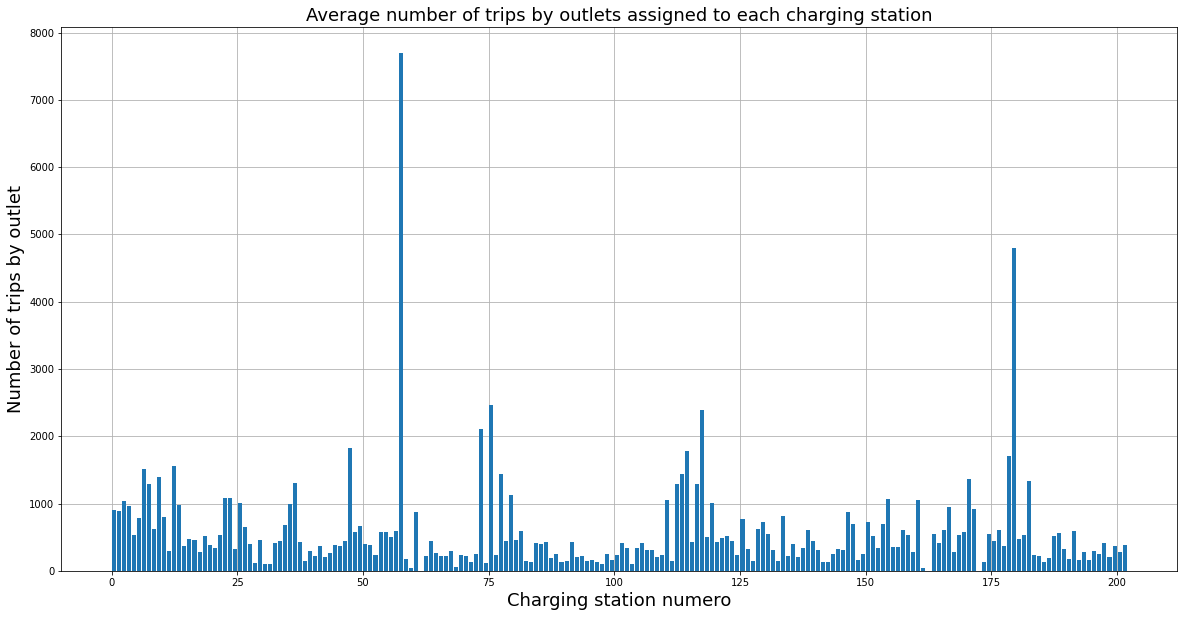

In [109]:
plotHistogram(df_chargingStations.tripCountByOutlet,[x -0.5 for x in list(range(1,len(df_chargingStations)+1))],
              'Average number of trips by outlets assigned to each charging station','Charging station numero',
              'Number of trips by outlet',width=0.8)

In [215]:
#Find the 15% and 85% quantiles for the number of trips by charging stations
qt=df_chargingStations.tripCount.quantile([.15, .85])
qt

0.15     4165.0
0.85    13160.6
Name: tripCount, dtype: float64

Cs with few assigned demand are the ones with less than 758 trips and the ones with a lot of assigned cs are the ones with more than 4900 assigned trips.

In [218]:
#Have a look at the location of the charging station with the highest demand
#Plot the heatmap of the demand locations
data=[np.vstack((df.endLatitude, df.endLongitude,0.005*np.ones(len(df)))).T.tolist()]
#heatmap=plotHeatmap(df.endLatitude, df.endLongitude,np.ones(len(df)))
heatmap=plotHeatmapWithTime(data,[1],5)

#Define what is a low and high number of assigned trips
lowNumberOfAssignedTrips=qt[0.15]
highNumberOfAssignedTrips=qt[0.85]

#Add the normal charging stations
df_cs_normalDemand=df_chargingStations.loc[(df_chargingStations.tripCount>lowNumberOfAssignedTrips)&\
                                           (df_chargingStations.tripCount<highNumberOfAssignedTrips),:]
heatmap=addPointsToMap(heatmap,df_cs_normalDemand.latitude,
        df_cs_normalDemand.longitude,["grey" for c in range(len(df_cs_normalDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations.tripCount>highNumberOfAssignedTrips),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["black" for c in range(len(df_cs_highDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations.tripCount<lowNumberOfAssignedTrips),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["blue" for c in range(len(df_cs_highDemand))],opacity=1)

In [300]:
#heatmap

The charging stations with few and a lot of assigned demand make sense. The cs with a lot of assigned demand are in the outer center of Cph where there are few cs while the ones with few assigned demands are the ones in the inner center close to a lot of cs. 

# Check that there are never more cars in charge than the number of available outlets

In [83]:
#Starting from the initial datetime and incrementing by 10 minutes until the last datetime, check that it never occurs
#that more cars than the number of plugs charge
number10minutesByMonth=6*24*31
base = dt.datetime(2019,9,1,0,0,0)
datetime_list = [base + dt.timedelta(minutes=10*x) for x in range(number10minutesByMonth+1)]
checks=[]

for csNumero in range(100,110): #1,len(df_chargingStations)+1):
    print(csNumero)

    nbOutlets=np.sum(df_chargingStations.loc[csNumero,'nbOutlets'])
    time=datetime_list[0]
    #Select the trips charged by the charging station
    df1=df[(df.selectedCS==csNumero)&(df.charge==1)]

    for time in datetime_list:

        #Check that the number of charges occuring at the specified time are smaller than the number of outlets
        checks.append(len(df1[(df1.gpsRecordedAtCET_endTrip<time)&(df1.endCharge>time)])<=nbOutlets)
        
print("There are never more outlets than available in use:",np.all(checks))

100
101
102
103
104
105
106
107
108
109
There are never more outlets than available in use: True


# Check the number of charges and served demand by charge power

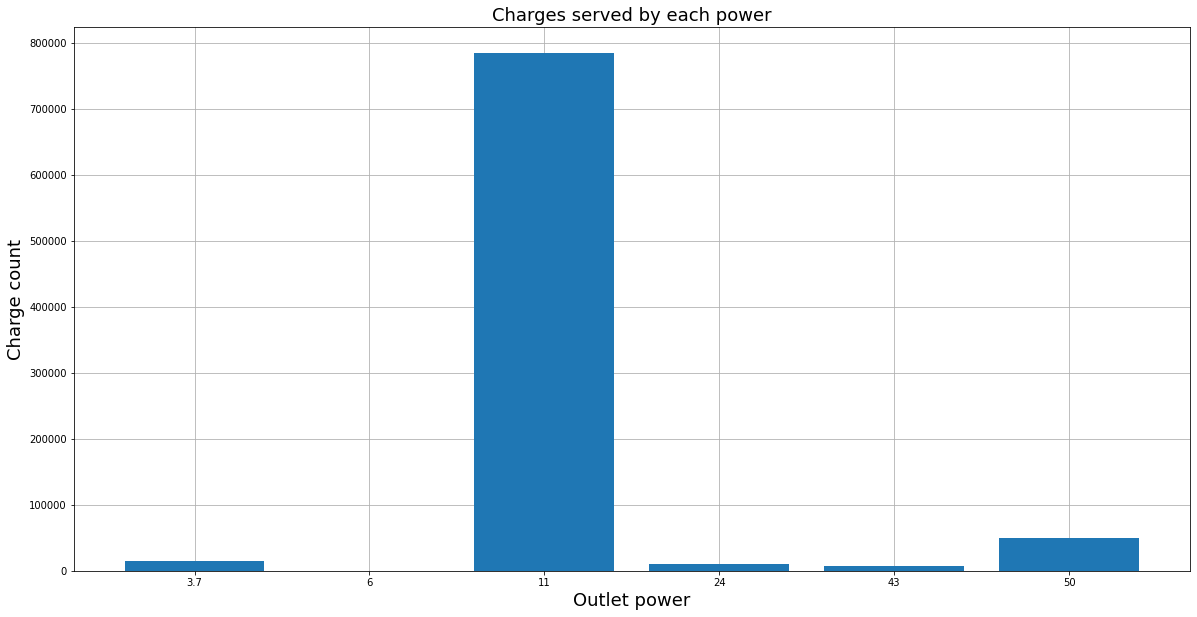

In [86]:
outletPower = [3.7, 6, 11, 24, 43, 50]
df_power = df[['powerToCharge','tripCount','servedDemand']].groupby('powerToCharge').sum()

plotHistogram(df_power.servedDemand,[str(power) for power in outletPower],'Charges served by each power','Outlet power',
             'Charge count')

In [88]:
#Assess the percentage of served demand for each charging power
df_power['%servedDemand']=np.floor(100*df_power.servedDemand/df_power.servedDemand.sum())
df_power['%servedDemand']

powerToCharge
3.7      1.0
6.0      0.0
11.0    90.0
24.0     1.0
43.0     0.0
50.0     5.0
Name: %servedDemand, dtype: float32

The percentage of served demand for each power corresponds to the percentage of supply for each power. (Apart for the 43kWh power)

In [91]:
#Have a look at the number of assigned trips for 43kWh cs
df_chargingStations['hasA43kWhOutlet']=df_chargingStations.powerOutlets.apply(lambda x: 43 in x)
df_chargingStations[df_chargingStations['hasA43kWhOutlet']==True].tripCount

3      2150.0
37     2700.0
46     1397.0
49     1154.0
50     1312.0
114    2941.0
123     958.0
130    1456.0
155    2109.0
189    1171.0
199    1150.0
Name: tripCount, dtype: float64

As the number of trips assigned for cs with 43kWh are quite low and the outlet 43kWh is chosen after the 50kWh one, it is expected that the 43kWh outlets are less used.

# Have a look at the demand, supply and unserved demand by hour

In [225]:
penetrationRate=0.1
perimeterInKm=1
df=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_unservedDemandByHour_experiment3_aggregatedByLocation_penetrationRate='+\
             str(penetrationRate)+'_PerimeterInKm='+str(perimeterInKm))

Average percentage of used supply: 0.3214704905384855
Unserved demand as a percentage of supply: 0.35254933189428744
Demand as a percentage of supply: 0.6740198887604785


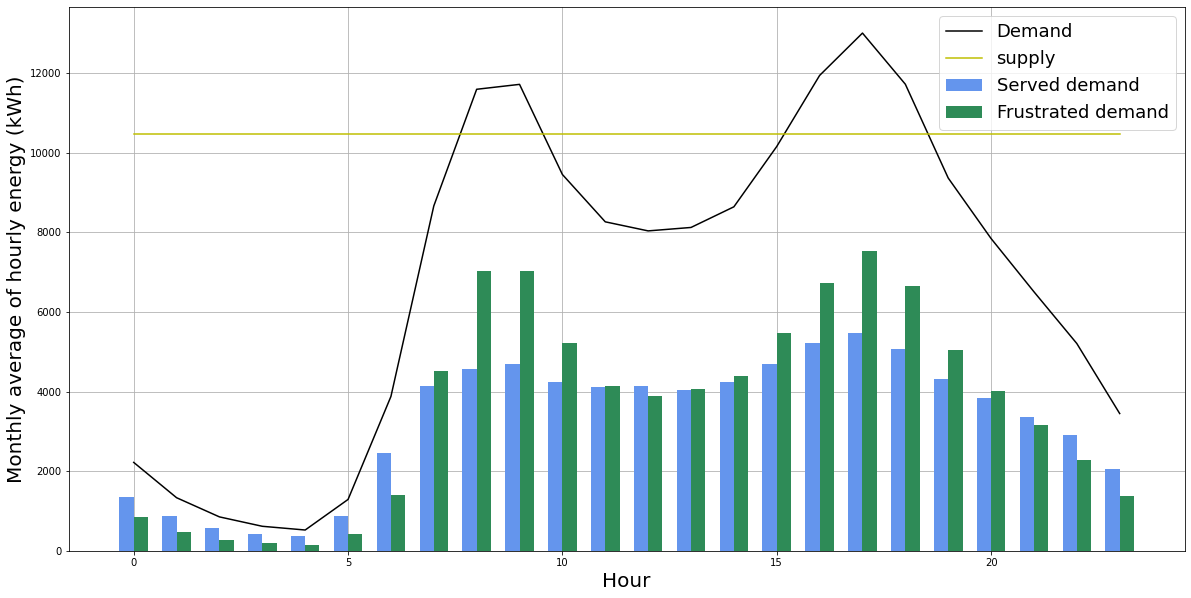

In [230]:
print("Average percentage of used supply:",df.servedDemand.sum()/df_chargingStations.supplyByMonth.sum()) 
print("Unserved demand as a percentage of supply:",df.unservedDemand.sum()/df_chargingStations.supplyByMonth.sum()) 
print("Demand as a percentage of supply:",df.demand.sum()/df_chargingStations.supplyByMonth.sum())

#Calculate the unserved demand by hour
fig, ax = plt.subplots(figsize=(20,10))

#Plot the unserved demand, minimum unserved demand and the demand by hour
#minUnservedDemand = pd.Series([np.floor(df['demandAt'+str(hour)].sum()-(df_chargingStations.supplyByMonthForOneHour).sum())
             #for hour in hours])
#Replace negative minimum unserved demand by 0
#minUnservedDemand = np.where(minUnservedDemand<0,0,minUnservedDemand)
servedDemand=[np.floor(df['servedDemand_h'+str(hour)].sum()/30) for hour in hours]
unservedDemand = [np.floor(df['unservedDemand_h'+str(hour)].sum()/30) for hour in hours]
demand=[df['demandAt'+str(hour)].sum()/30 for hour in hours]
supply=[df_chargingStations.supplyByMonthForOneHour.sum()/30 for hour in hours]

width = 1/3 
ax.bar(np.add(hours, -width/2), servedDemand, width=width, facecolor='cornflowerblue',label='Served demand')
ax.bar(np.add(hours, width/2), unservedDemand, width=width, facecolor='seagreen',label='Frustrated demand')
plt.plot(hours,demand,label='Demand',color='k')
plt.plot(hours,supply,label='supply',color='y')

#Make it nice and comprehensive
#ax.set_title("Served and frustrated hourly demand along with hourly supply and demand", fontsize=18)
ax.set_xlabel("Hour", fontsize=20)
ax.set_ylabel("Monthly average of hourly energy (kWh)", fontsize=20)
ax.grid(True)
ax.set_axisbelow(True)
leg = ax.legend(fontsize=18);

The served demand is way lower than the supply. It means that the supply cannot be entirely used. What are the reasons for it? 

# Have a look at the distribution of the utilization rate by hour

In [288]:
penetrationRate=0.1
perimeterInKm=1
df_chargingStations=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_chargingStations_penetrationRate='+str(penetrationRate)+
                '_PerimeterInKm='+str(perimeterInKm)+'Experiment3')

In [289]:
print("Mean utilization rate:",df_chargingStations.utilizationRate.mean())

Mean utilization rate: 0.3661943898235697


The mean utilization rate is not particularly high, due to low utilization during night.

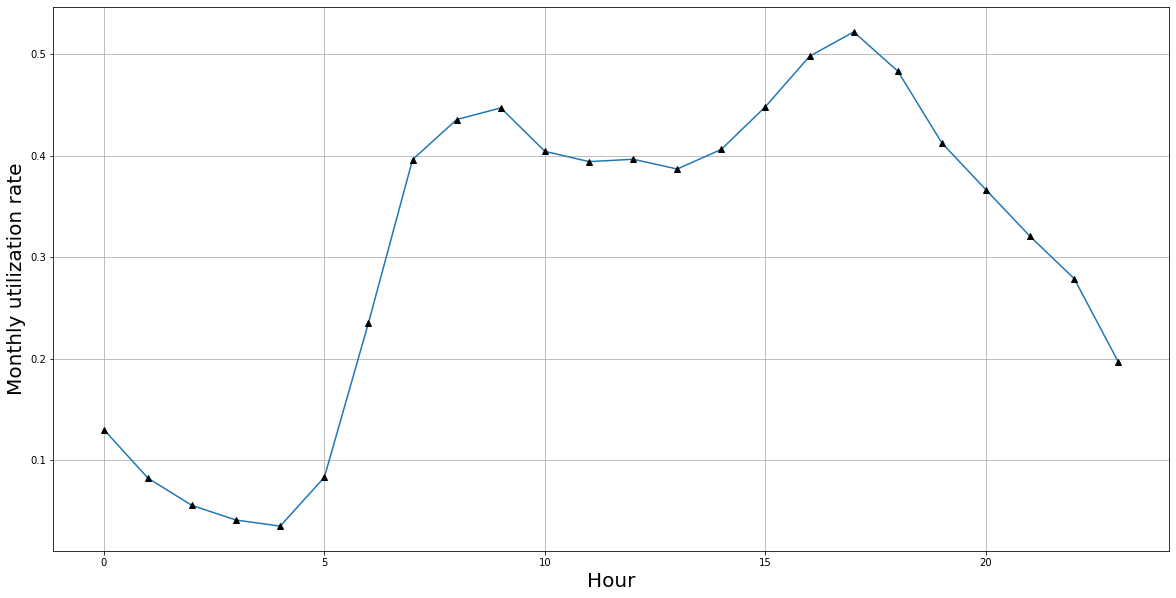

In [290]:
hours=list(range(24))
meanUtilizationRate=[]
for h in hours:
    meanUtilizationRate.append(df_chargingStations['servedDemand_h'+str(h)].sum()/df_chargingStations.supplyByMonthForOneHour.sum())

plt.plot(hours,meanUtilizationRate)
plt.plot(hours,meanUtilizationRate,'^',color='black')
plt.xlabel('Hour',fontsize=20)
plt.ylabel("Monthly utilization rate",fontsize=20)
plt.grid()

Even during peak hours the charging stations are not used more than 60%. This is due to the fact that some charging stations are less used during these peak hours and even with high demand, some charging stations are not fully used. See distribution of utilization rate by hour later on.

# Have a look at the utilization rates

In [291]:
df_chargingStations=pd.read_pickle(fileDirectory+'data/4_ServeTheDemand_Experiment3/df_chargingStations_penetrationRate='+str(penetrationRate)+
                '_PerimeterInKm='+str(perimeterInKm)+'Experiment3')

The average utilization rate is: 0.3661943898235697


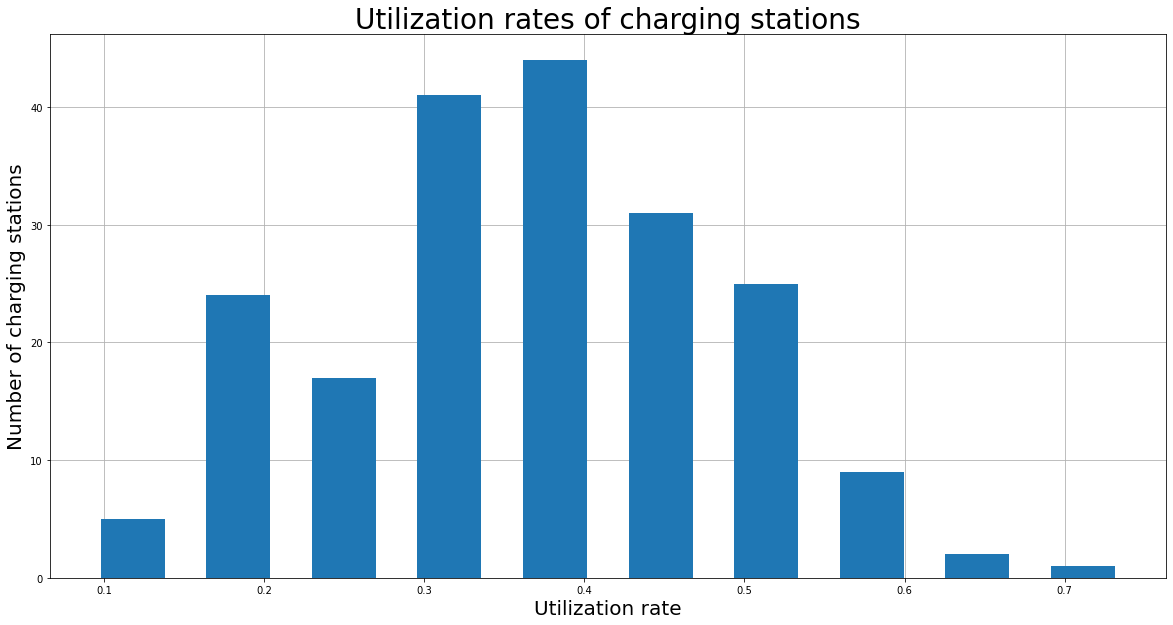

In [292]:
print("The average utilization rate is:",df_chargingStations.utilizationRate.dropna().mean())

counts, labels = np.histogram(df_chargingStations.utilizationRate.dropna(),bins=10)
labels=(labels[:-1]+labels[1:])/2
plotHistogram(counts,labels,'Utilization rates of charging stations','Utilization rate',
              'Number of charging stations',width=0.04)

In general, the low utilization rate during the night pushes down the mean utilization rate. No cs have utilization rates higher than 70% as the demand and therefore the utilization rate during the nigh is quite low. 

Average percentage of unserved demand 0.85995746
The average percentage of unserved demand by charging station is: 0.38852957


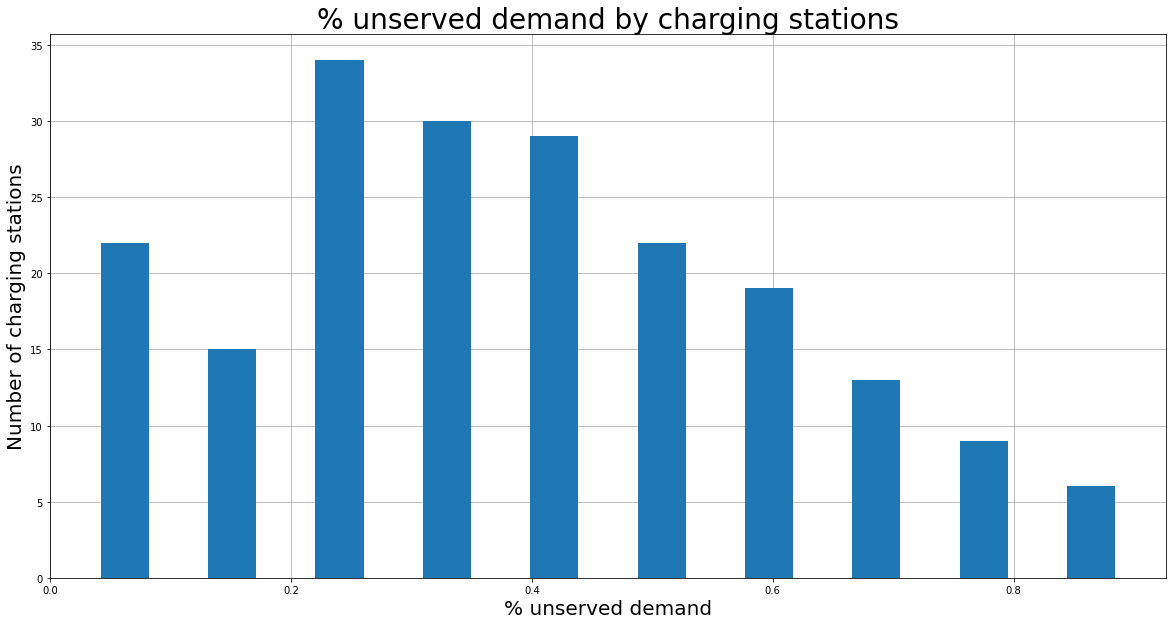

In [293]:
#Have a look at the % of unserved demand by charging station
print("Average percentage of unserved demand",df.unservedDemand.sum()/df.demand.sum())
print("The average percentage of unserved demand by charging station is:",df_chargingStations['%unservedDemand'].dropna().mean())

counts, labels = np.histogram(df_chargingStations['%unservedDemand'].dropna(),bins=10)
labels=(labels[:-1]+labels[1:])/2
plotHistogram(counts,labels,'% unserved demand by charging stations','% unserved demand',
              'Number of charging stations',width=0.04)

Some charging station don't serve a lot of their demand, as they have high unserved demand. They are likely to be the charging stations with very high demand that they cannot handle.

# Have a look charging stations with high % of unserved demand

In [301]:
#Have a look at the location of the charging station with the highest % unserved demand
#Plot the heatmap of the demand locations
data=[np.vstack((df.endLatitude, df.endLongitude,0.01*np.ones(len(df)))).T.tolist()]
#heatmap=plotHeatmap(df.endLatitude, df.endLongitude,np.ones(len(df)))
heatmap=plotHeatmapWithTime(data,[1],5)

#Find the 15% and 85% quantiles for the number of trips by outlet
qt=df_chargingStations['%unservedDemand'].quantile([.15, .85])

#Define what is a low and high number of assigned trips
lowUnservedDemand=qt[0.15]
highUnservedDemand=qt[0.85]

#Add the normal charging stations
df_cs_normalDemand=df_chargingStations.loc[(df_chargingStations['%unservedDemand']>lowUnservedDemand)&\
                                           (df_chargingStations['%unservedDemand']<highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_normalDemand.latitude,
        df_cs_normalDemand.longitude,["grey" for c in range(len(df_cs_normalDemand))],opacity=1)

#Plot the charging stations with high unserved demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations['%unservedDemand']>highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["black" for c in range(len(df_cs_highDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_lowDemand=df_chargingStations.loc[(df_chargingStations['%unservedDemand']<lowUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_lowDemand.latitude,
        df_cs_lowDemand.longitude,["blue" for c in range(len(df_cs_lowDemand))],opacity=1)

#heatmap

# Charging station with utilization rate for a specific hour

In [302]:
#Have a look at the location of the charging station with the highest % unserved demand
#Plot the heatmap of the demand locations
df['scaledDemand']=df.demand/df.demand.max()
df1=df[df.scaledDemand>0.0001]
data=[np.vstack((df1.endLatitude, df1.endLongitude,df1.scaledDemand)).T.tolist()]
#heatmap=plotHeatmap(df.endLatitude, df.endLongitude,np.ones(len(df)))
heatmap=plotHeatmapWithTime(data,[1],5)

#Find the 15% and 85% quantiles for the number of trips by outlet
qt=df_chargingStations['utilizationRate'].quantile([.15, .85])

#Define what is a low and high number of assigned trips
lowUnservedDemand=qt[0.15]
highUnservedDemand=qt[0.85]

#Add the normal charging stations
df_cs_normalDemand=df_chargingStations.loc[(df_chargingStations.utilizationRate>lowUnservedDemand)&\
                                           (df_chargingStations.utilizationRate<highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_normalDemand.latitude,
        df_cs_normalDemand.longitude,["grey" for c in range(len(df_cs_normalDemand))],opacity=1)

#Plot the charging stations with high unserved demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations.utilizationRate>highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["black" for c in range(len(df_cs_highDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_lowDemand=df_chargingStations.loc[(df_chargingStations.utilizationRate<lowUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_lowDemand.latitude,
        df_cs_lowDemand.longitude,["blue" for c in range(len(df_cs_lowDemand))],opacity=1)

#heatmap

In [303]:
#SAME HEATMAP THAN BEFORE BUT FOR 8 A.M.

#Have a look at the location of the charging station with the highest % unserved demand
#Plot the heatmap of the demand locations
df['scaledDemandAt8']=df.demandAt8/df.demandAt8.max()
df1=df[df.scaledDemandAt8!=0]
data=[np.vstack((df1.endLatitude, df1.endLongitude,df1.scaledDemandAt8)).T.tolist()]
#heatmap=plotHeatmap(df.endLatitude, df.endLongitude,np.ones(len(df)))
heatmap=plotHeatmapWithTime(data,[1],5)

#Find the 15% and 85% quantiles for the number of trips by outlet
qt=df_chargingStations['utilizationRateAt8'].quantile([.15, .85])

#Define what is a low and high number of assigned trips
lowUnservedDemand=qt[0.15]
highUnservedDemand=qt[0.85]

#Add the normal charging stations
df_cs_normalDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt8>lowUnservedDemand)&\
                                           (df_chargingStations.utilizationRateAt8<highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_normalDemand.latitude,
        df_cs_normalDemand.longitude,["grey" for c in range(len(df_cs_normalDemand))],opacity=1)

#Plot the charging stations with high unserved demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt8>highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["black" for c in range(len(df_cs_highDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_lowDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt8<lowUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_lowDemand.latitude,
        df_cs_lowDemand.longitude,["blue" for c in range(len(df_cs_lowDemand))],opacity=1)

#heatmap

In [304]:
#SAME HEATMAP THAN BEFORE BUT FOR 5 P.M.

#Have a look at the location of the charging station with the highest % unserved demand
#Plot the heatmap of the demand locations
df['scaledDemandAt17']=df.demandAt17/df.demandAt17.max()
df1=df[df.scaledDemandAt17!=0]
data=[np.vstack((df1.endLatitude, df1.endLongitude,df1.scaledDemandAt17)).T.tolist()]
#heatmap=plotHeatmap(df.endLatitude, df.endLongitude,np.ones(len(df)))
heatmap=plotHeatmapWithTime(data,[1],5)

#Find the 15% and 85% quantiles for the number of trips by outlet
qt=df_chargingStations['utilizationRateAt17'].quantile([.15, .85])

#Define what is a low and high number of assigned trips
lowUnservedDemand=qt[0.15]
highUnservedDemand=qt[0.85]

#Add the normal charging stations
df_cs_normalDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt17>lowUnservedDemand)&\
                                           (df_chargingStations.utilizationRateAt17<highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_normalDemand.latitude,
        df_cs_normalDemand.longitude,["grey" for c in range(len(df_cs_normalDemand))],opacity=1)

#Plot the charging stations with high unserved demand in another color
df_cs_highDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt17>highUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_highDemand.latitude,
        df_cs_highDemand.longitude,["black" for c in range(len(df_cs_highDemand))],opacity=1)

#Plot the charging stations with high demand in another color
df_cs_lowDemand=df_chargingStations.loc[(df_chargingStations.utilizationRateAt17<lowUnservedDemand),:]
heatmap=addPointsToMap(heatmap,df_cs_lowDemand.latitude,
        df_cs_lowDemand.longitude,["blue" for c in range(len(df_cs_lowDemand))],opacity=1)

#heatmap

# Have a look at the demand in space by hour

In [174]:
maxDemandByHour=50 #Maximum 50kWh can be asked by hour as it is the maximum power
hours=list(range(24))
for h in hours: 
    df['scaledDemandAt'+str(h)]=df['demandAt'+str(h)]/maxDemandByHour

In [175]:
#Check that most of the demand is kept by filtering out some data
for h in hours:
    print('% scaled demand higher than 0.01:',df[df['scaledDemandAt'+str(h)]>0.01]['demandAt'+str(h)].sum()/\
          df['demandAt'+str(h)].sum())
    #print("% data kept:",len(df[df['scaledDemandAt'+str(h)]>0.01])/len(df))

% scaled demand higher than 0.01: 0.9999720573335668
% scaled demand higher than 0.01: 0.9999737948291505
% scaled demand higher than 0.01: 0.9999722782604236
% scaled demand higher than 0.01: 0.9999815475463147
% scaled demand higher than 0.01: 0.9999456648303586
% scaled demand higher than 0.01: 0.9999737958888153
% scaled demand higher than 0.01: 0.9999852374794833
% scaled demand higher than 0.01: 0.9999918800820162
% scaled demand higher than 0.01: 0.9999868663396178
% scaled demand higher than 0.01: 0.9999845958972415
% scaled demand higher than 0.01: 0.9999798068078058
% scaled demand higher than 0.01: 0.9999752671262984
% scaled demand higher than 0.01: 0.9999785193467255
% scaled demand higher than 0.01: 0.9999776468301009
% scaled demand higher than 0.01: 0.9999835498626358
% scaled demand higher than 0.01: 0.9999851859762244
% scaled demand higher than 0.01: 0.9999841448009915
% scaled demand higher than 0.01: 0.9999894531242782
% scaled demand higher than 0.01: 0.9999892820

Most of the demand is kept by keeping scaled demand higher than 0.01.

In [305]:
#Visualize the demand by hour
data=[]

#hours=list(range(24))
hours=[8,17]
for h in hours: 
    
    #Only select the points with high enough unserved demand as the other points don't represent much unserved demand
    df1=df[df['scaledDemandAt'+str(h)]>0.01]
    
    data.append(np.vstack((df1.endLatitude, df1.endLongitude,df1['scaledDemandAt'+str(h)])).T.tolist())
    
heatmapWithTime = plotHeatmapWithTime(data,hours)

#display(heatmapWithTime)

The demand evolves quite significantly with hours.

# Have a look at the distribution of the utilization rate by hour

<ipython-input-203-2d80fc2c80ef>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pylab.figure(figsize=(20,10))


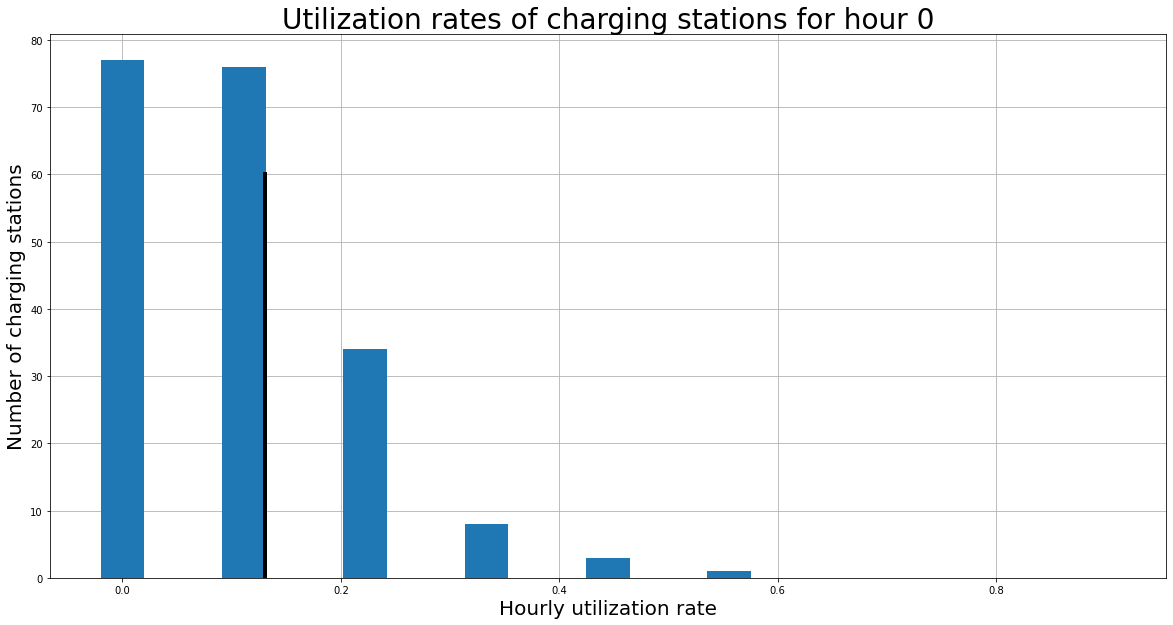

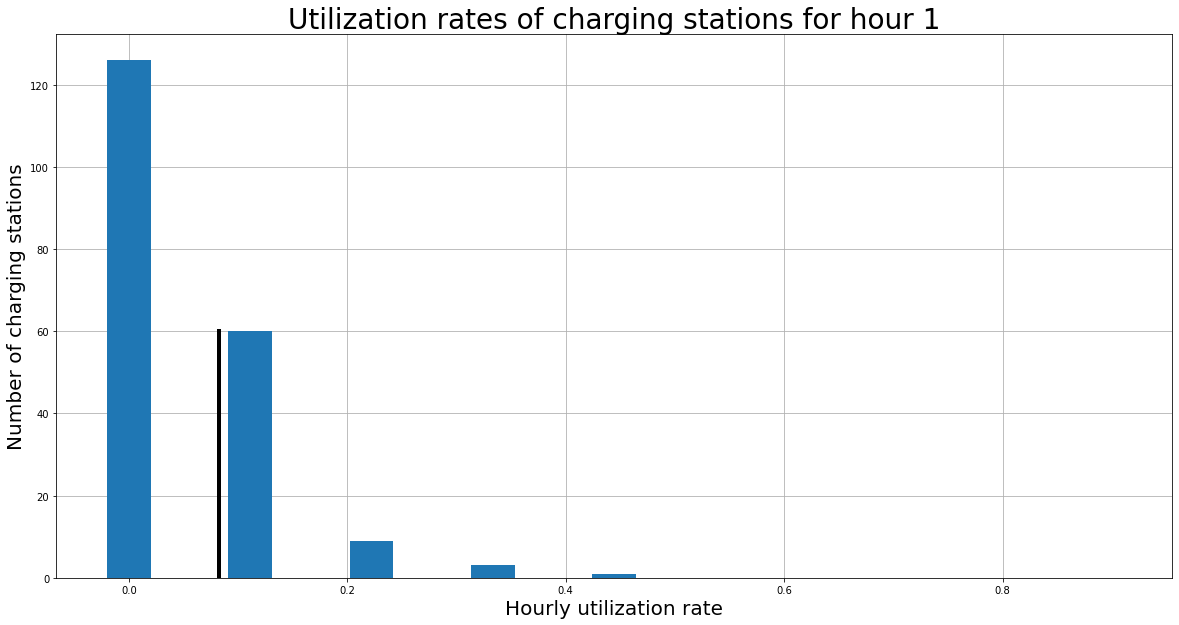

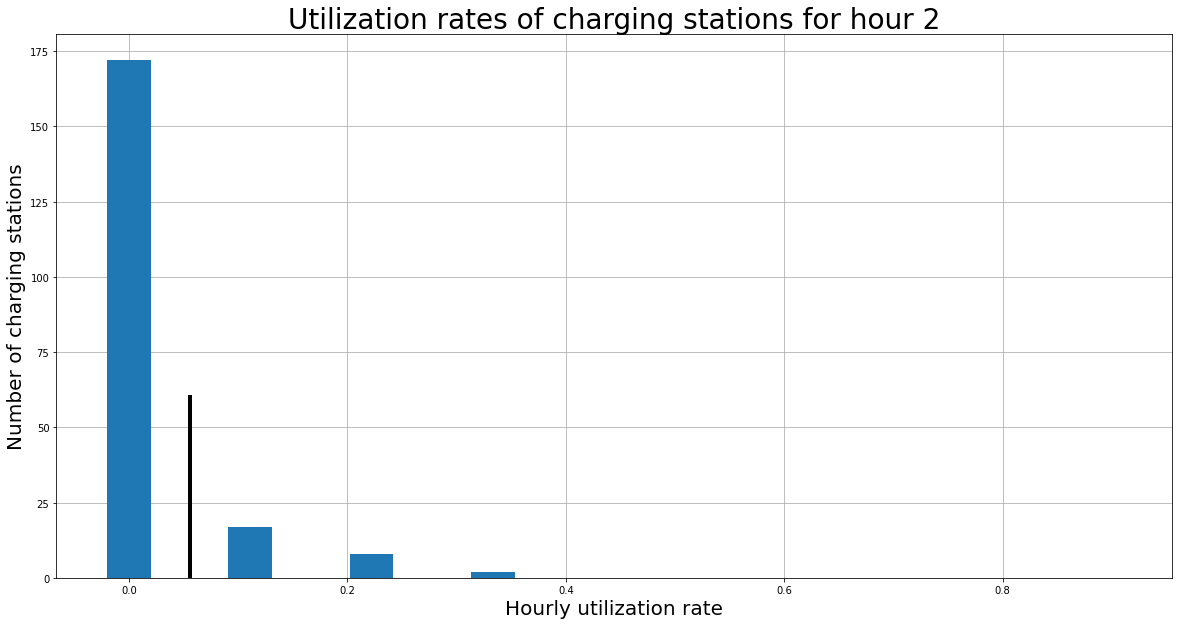

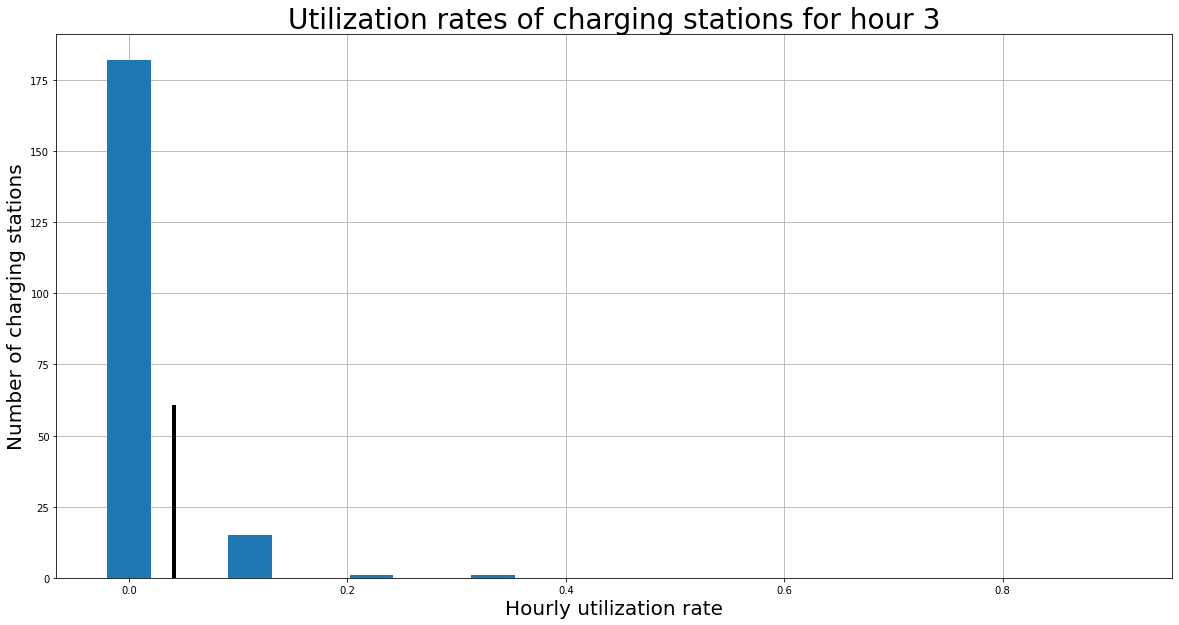

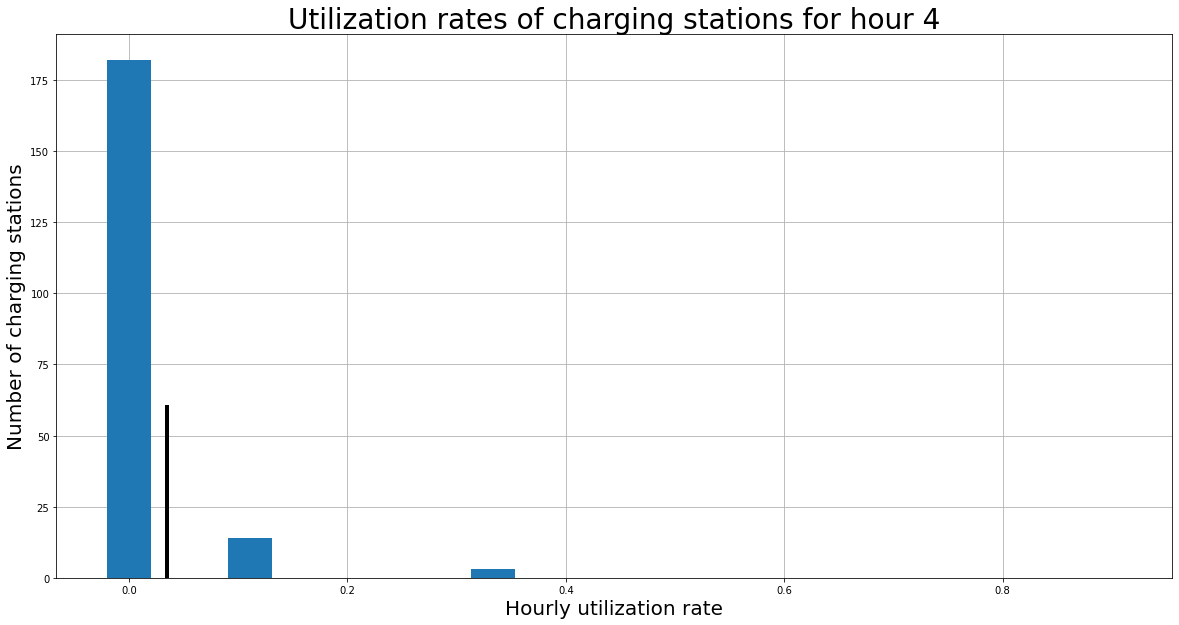

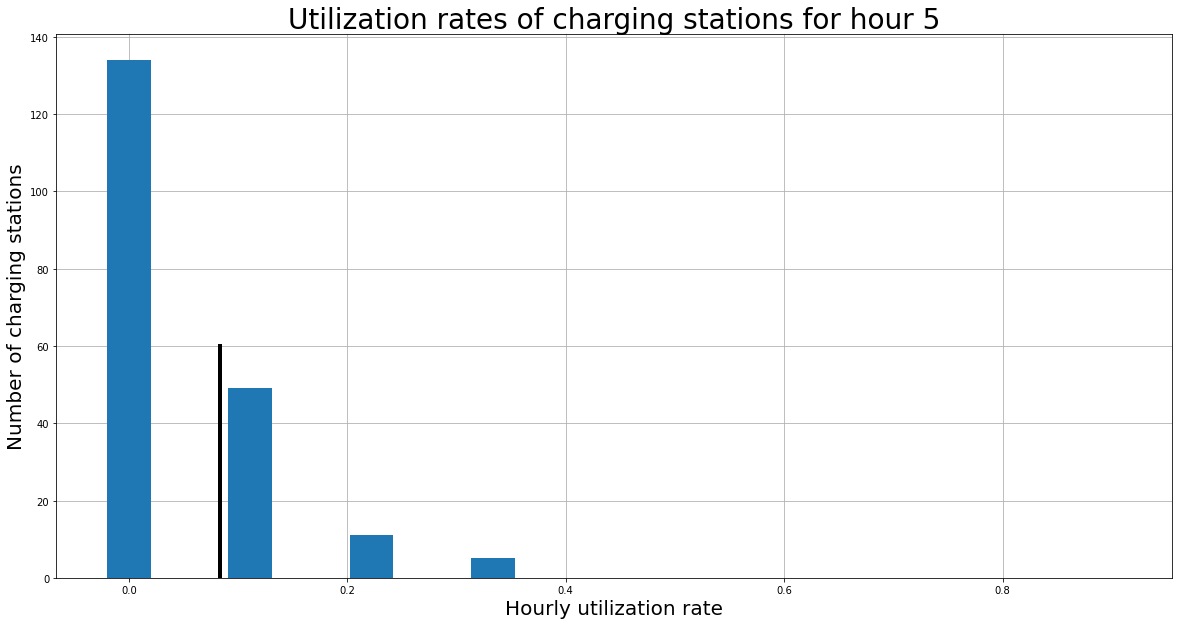

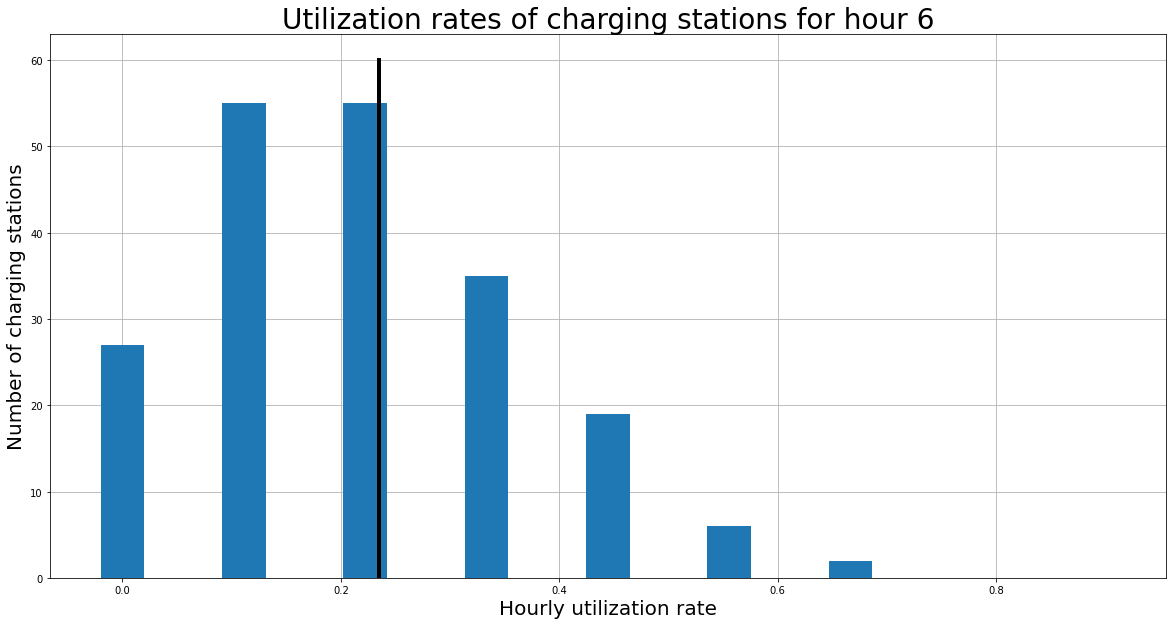

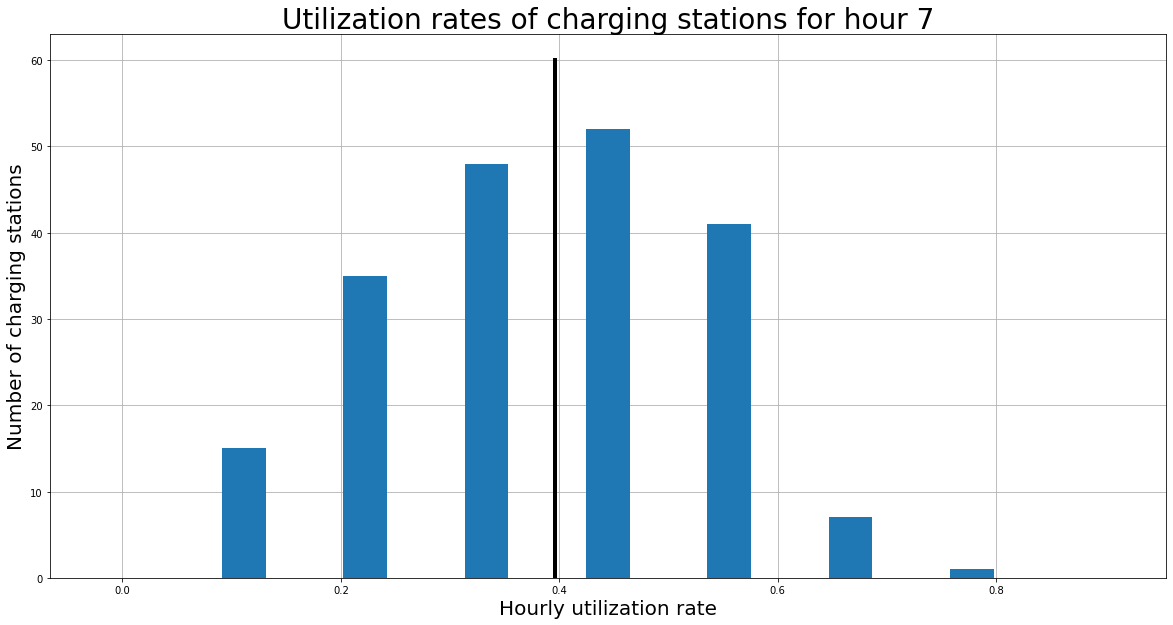

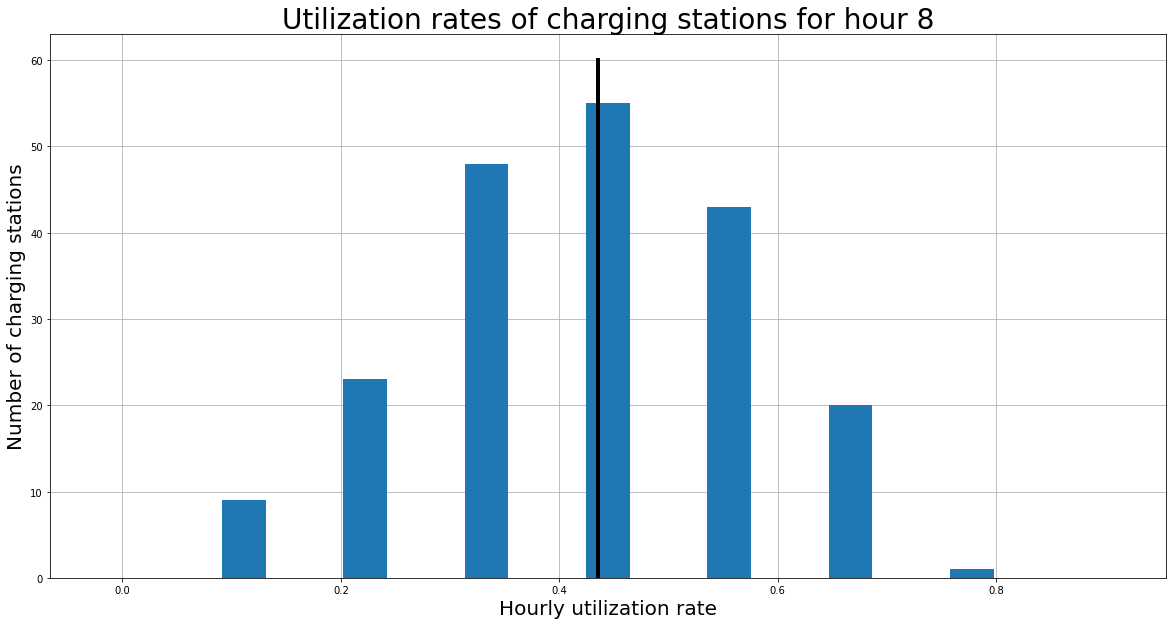

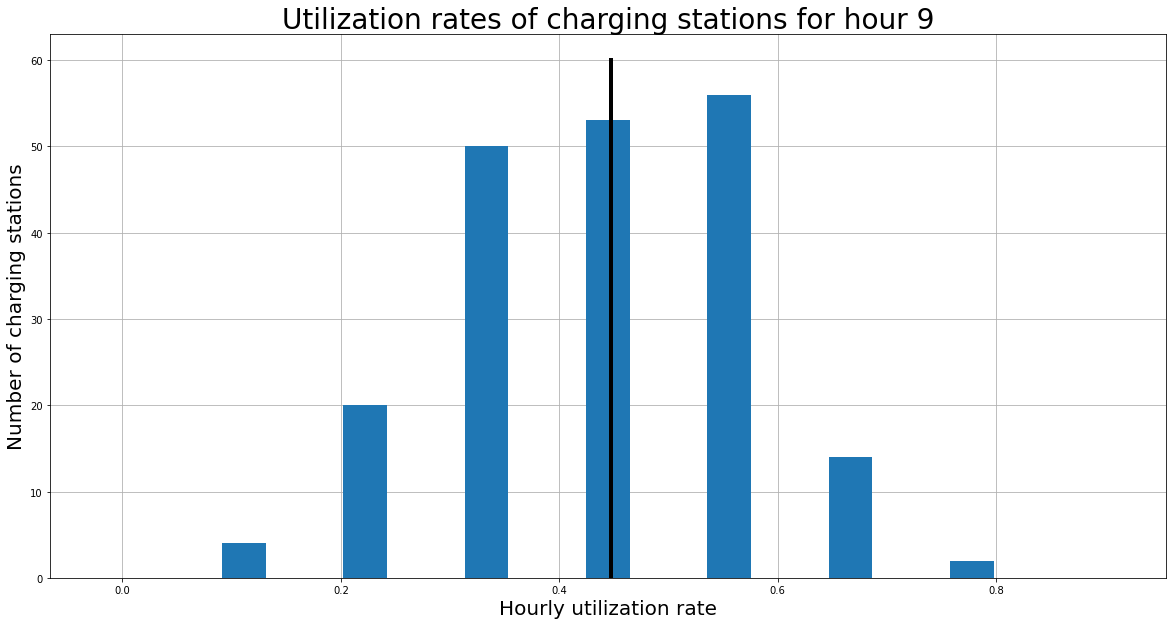

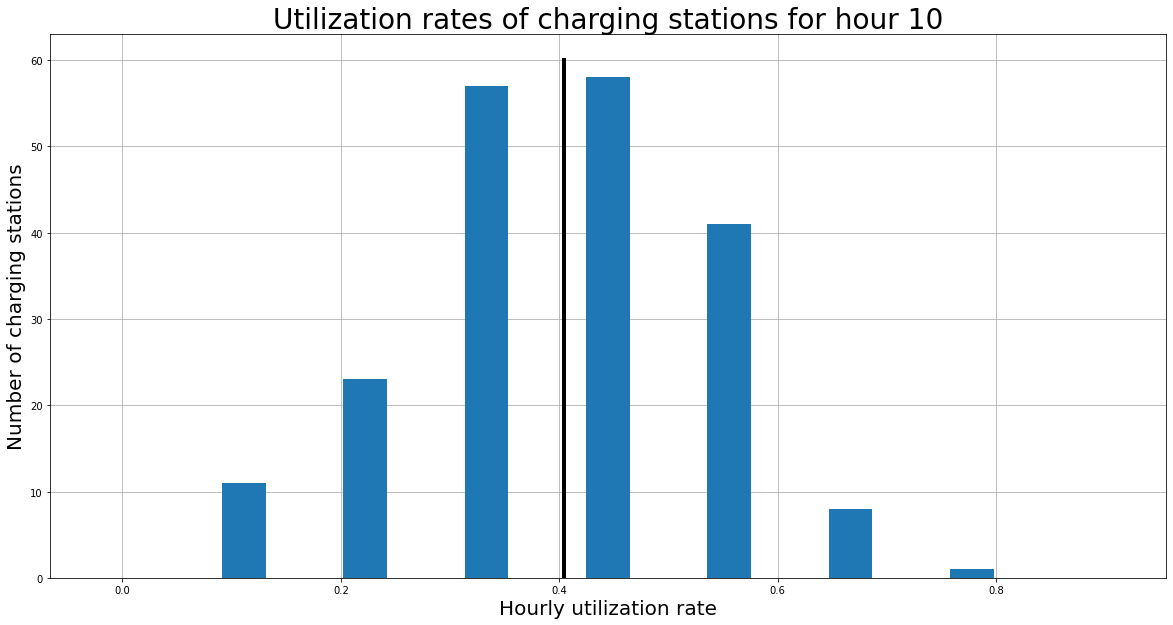

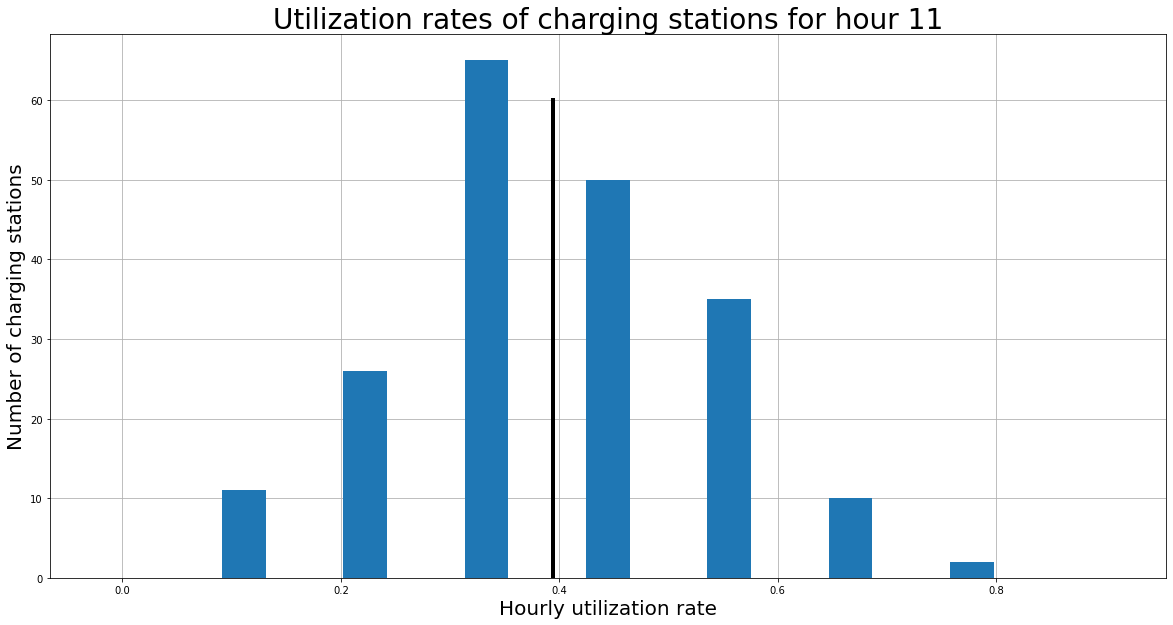

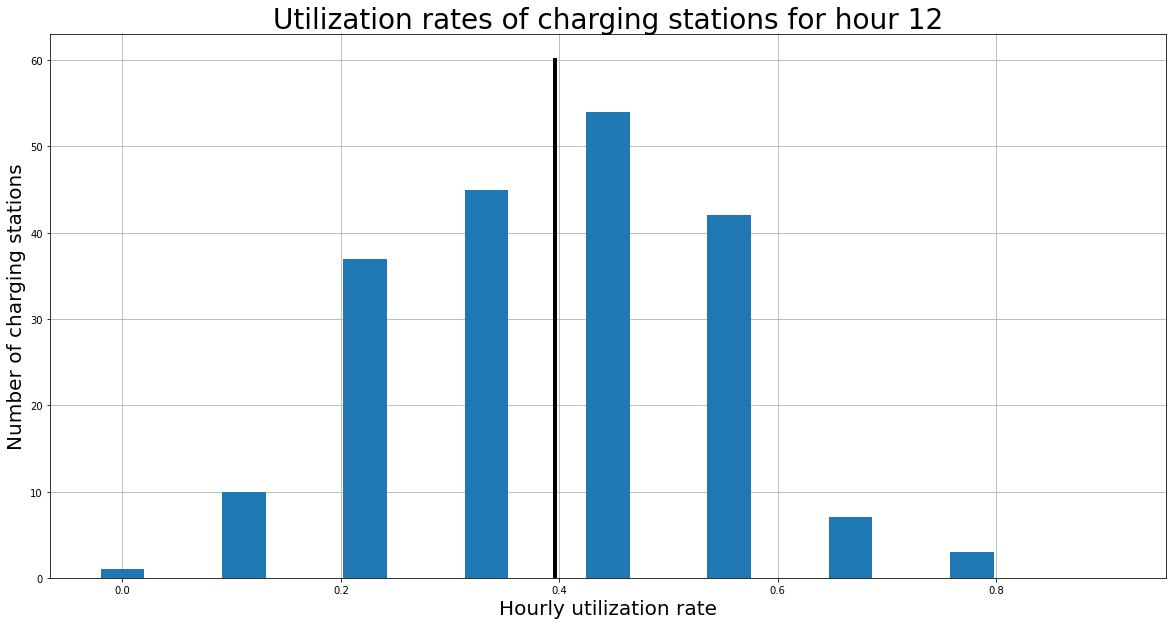

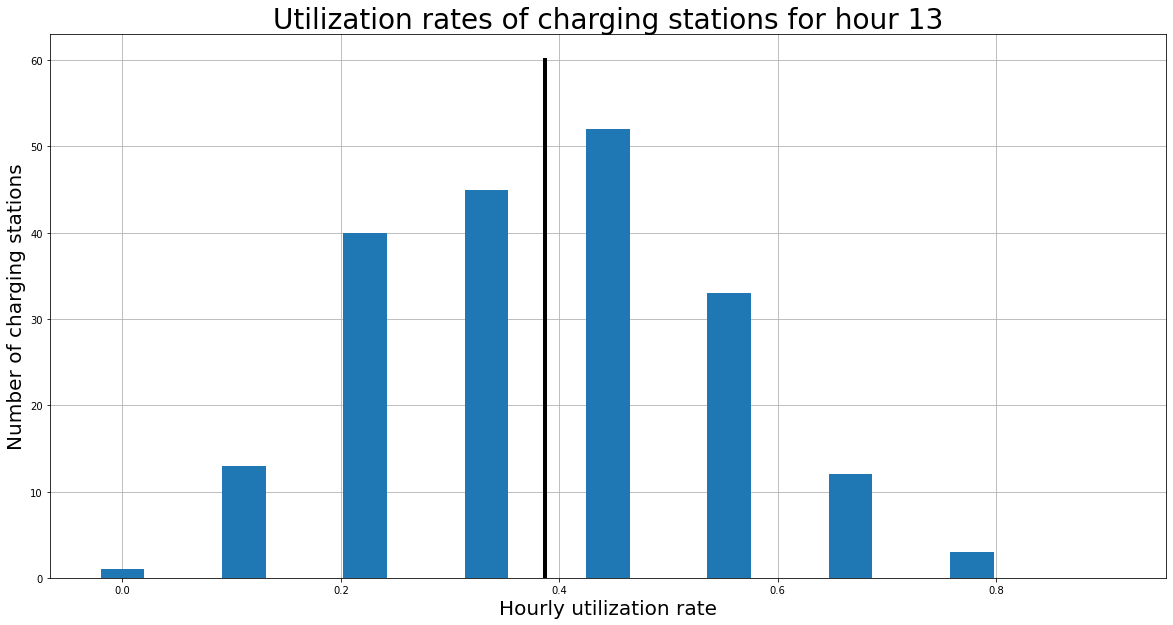

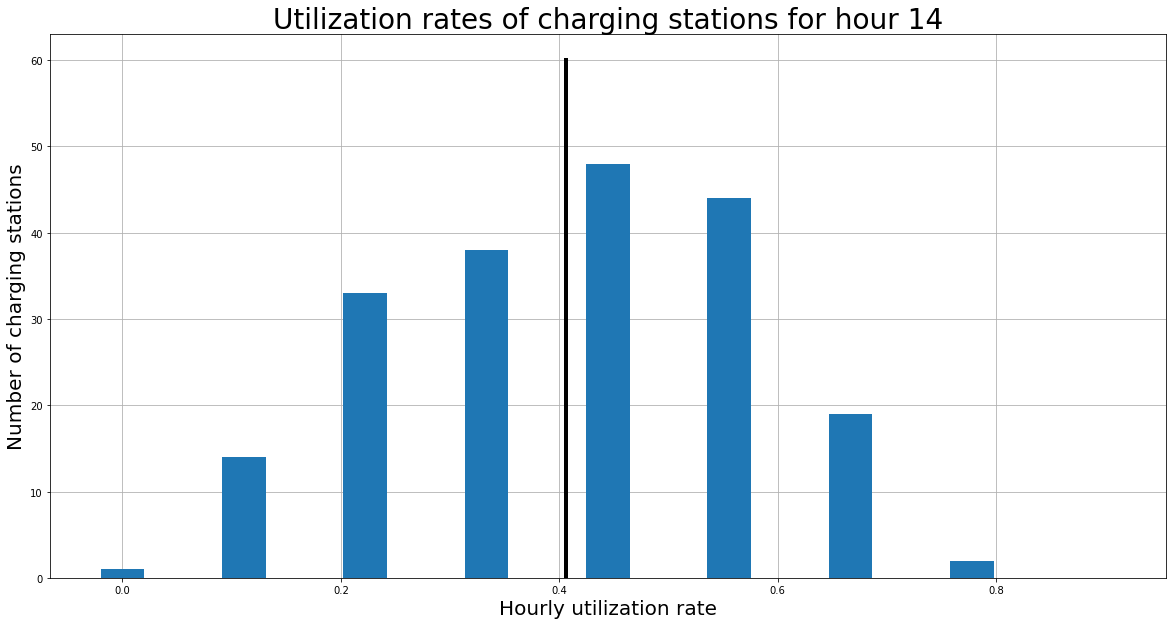

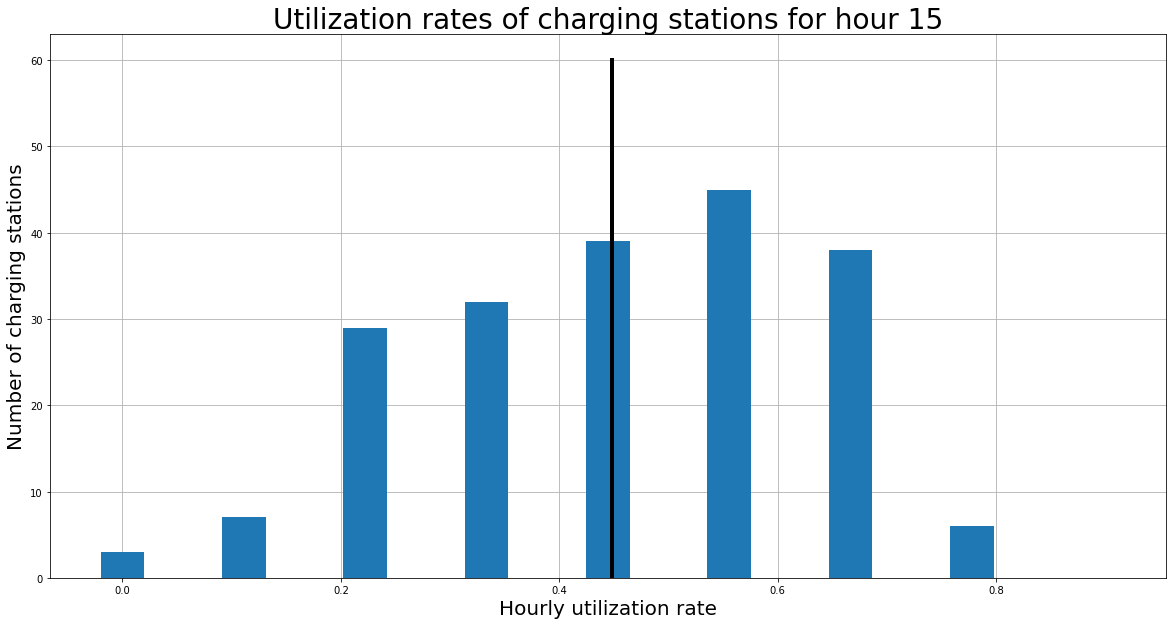

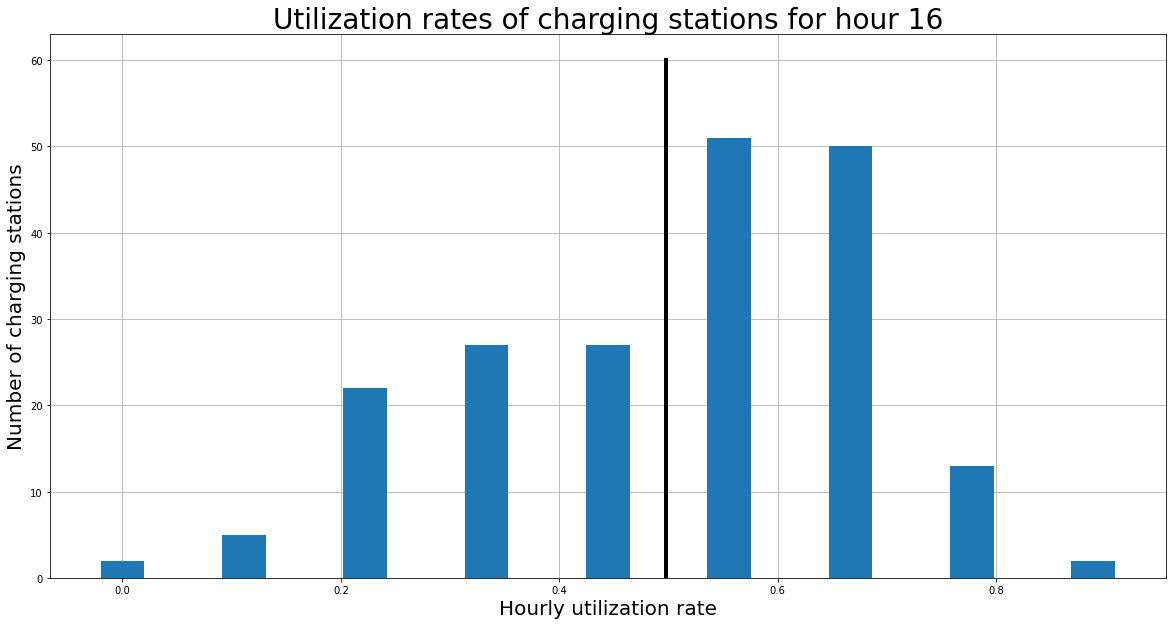

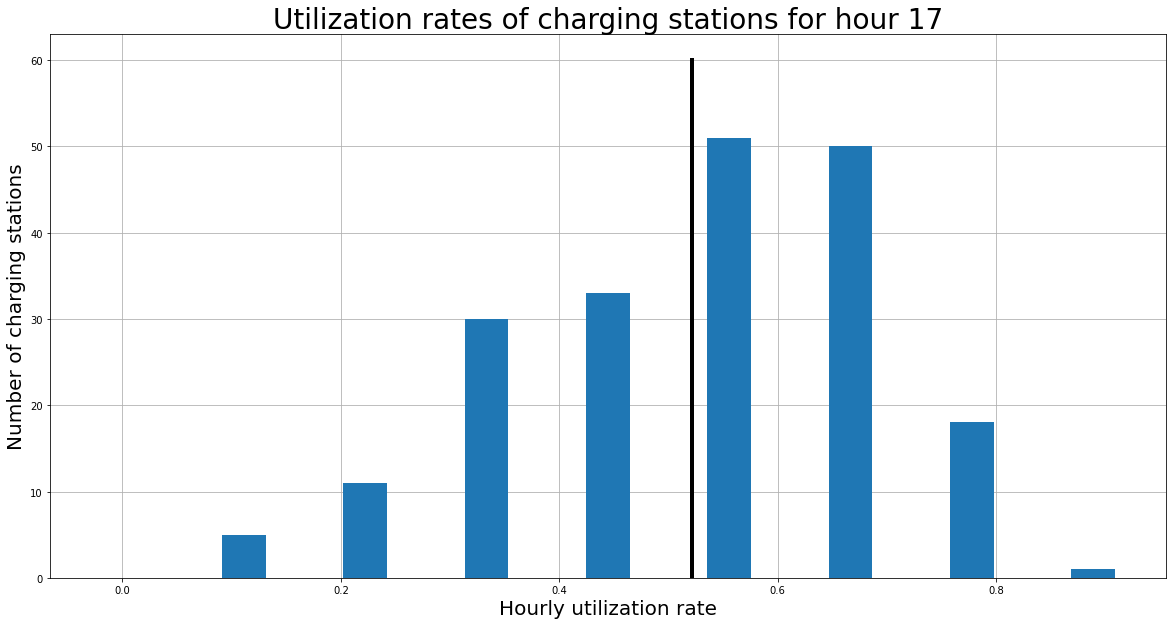

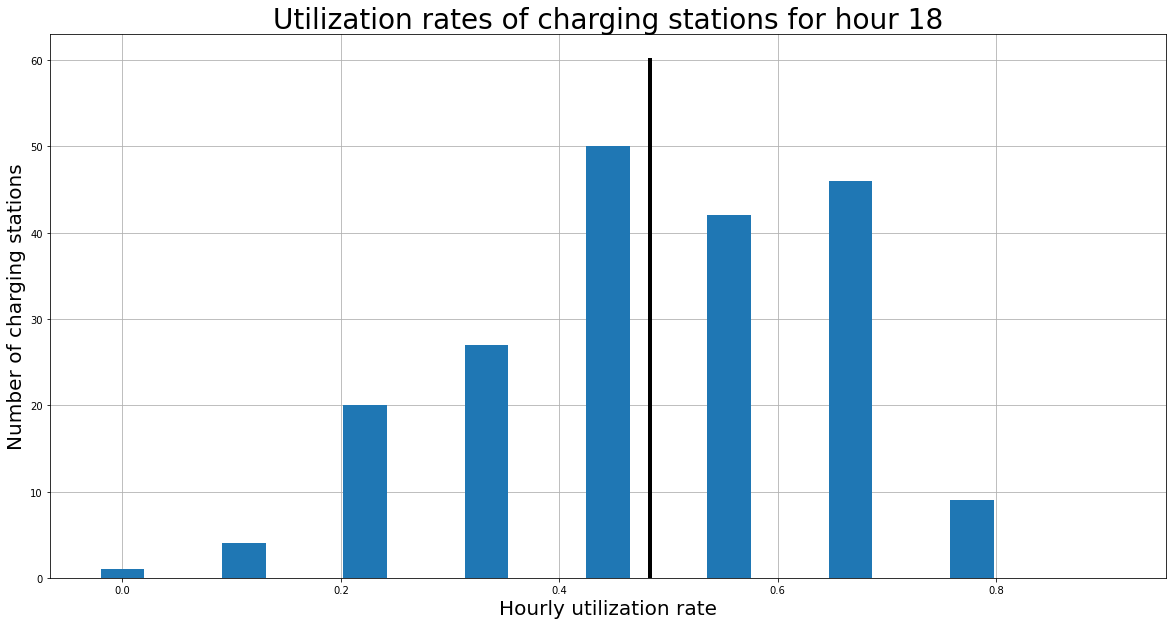

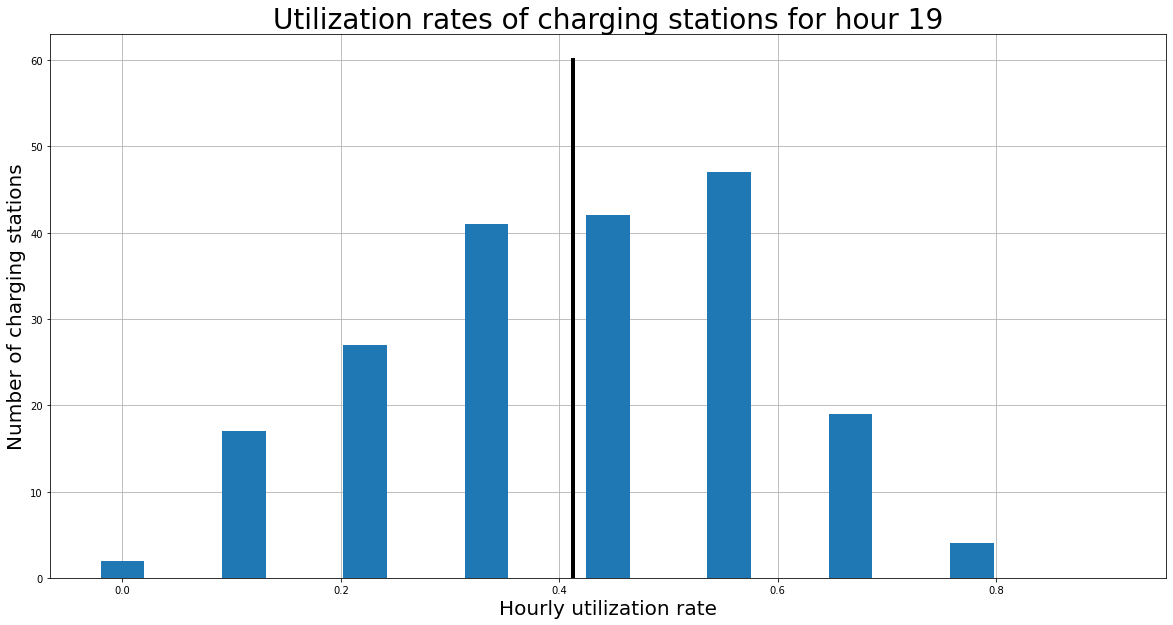

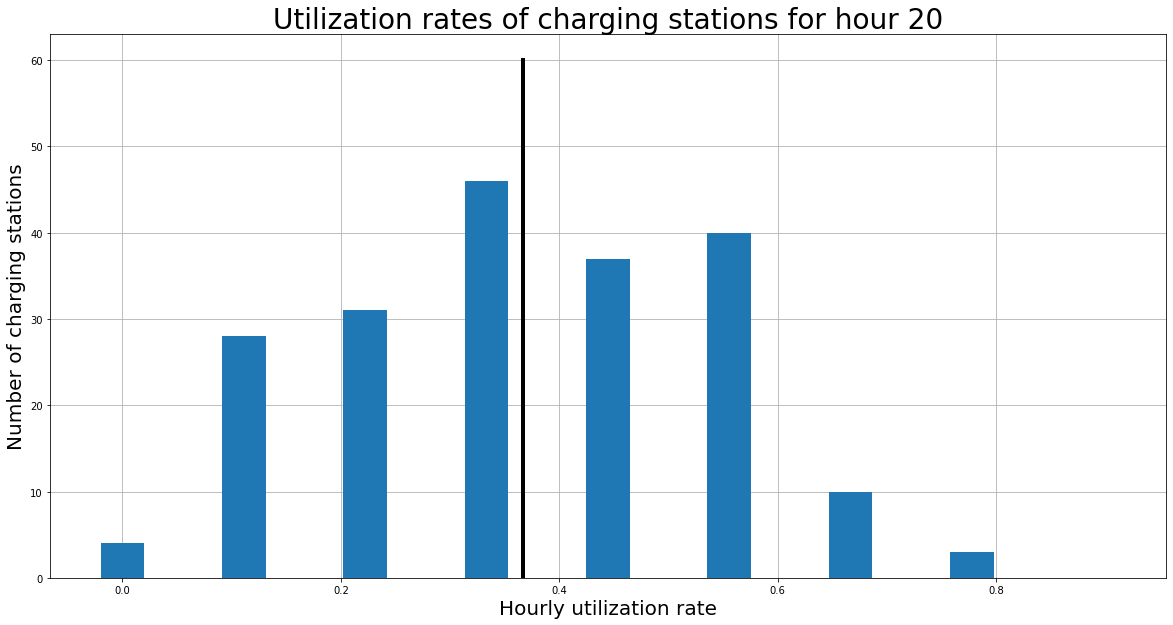

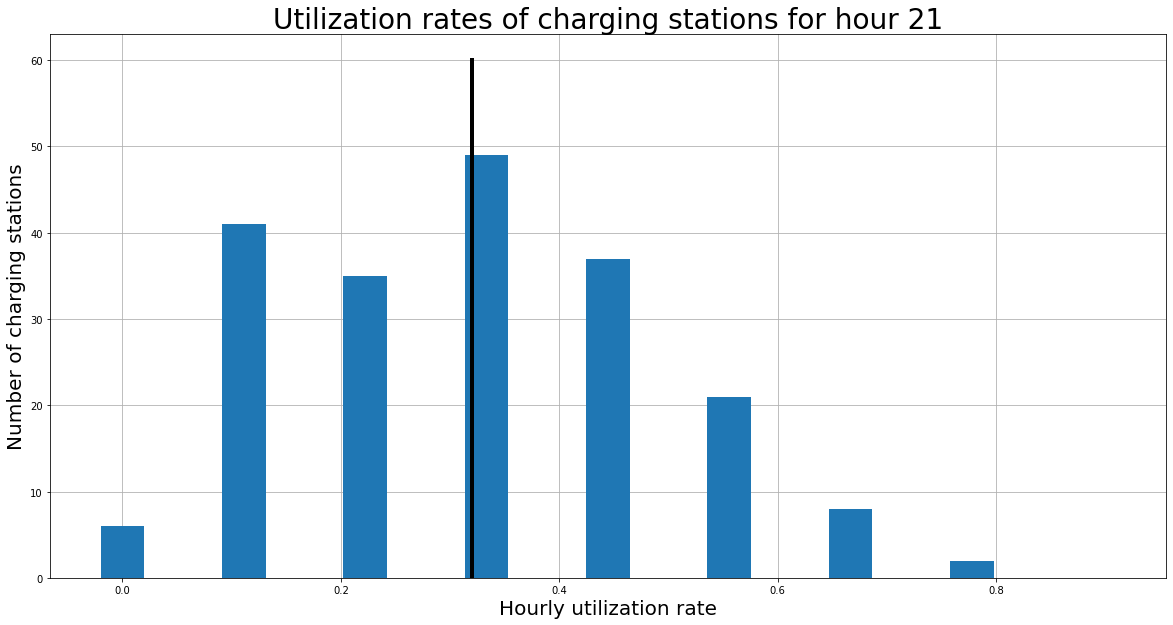

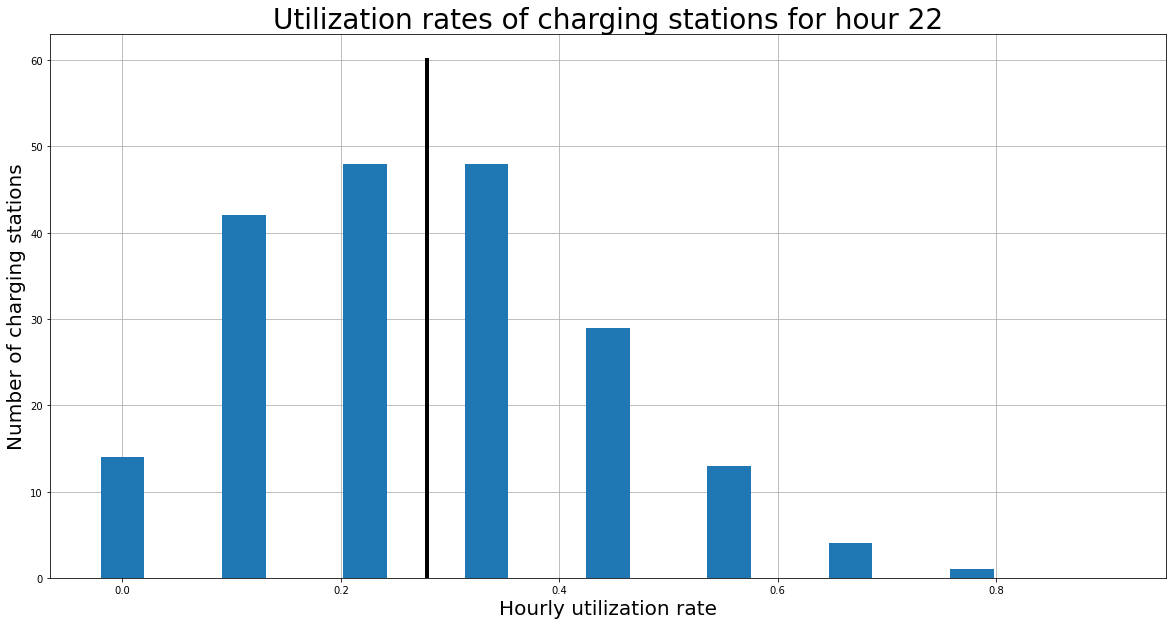

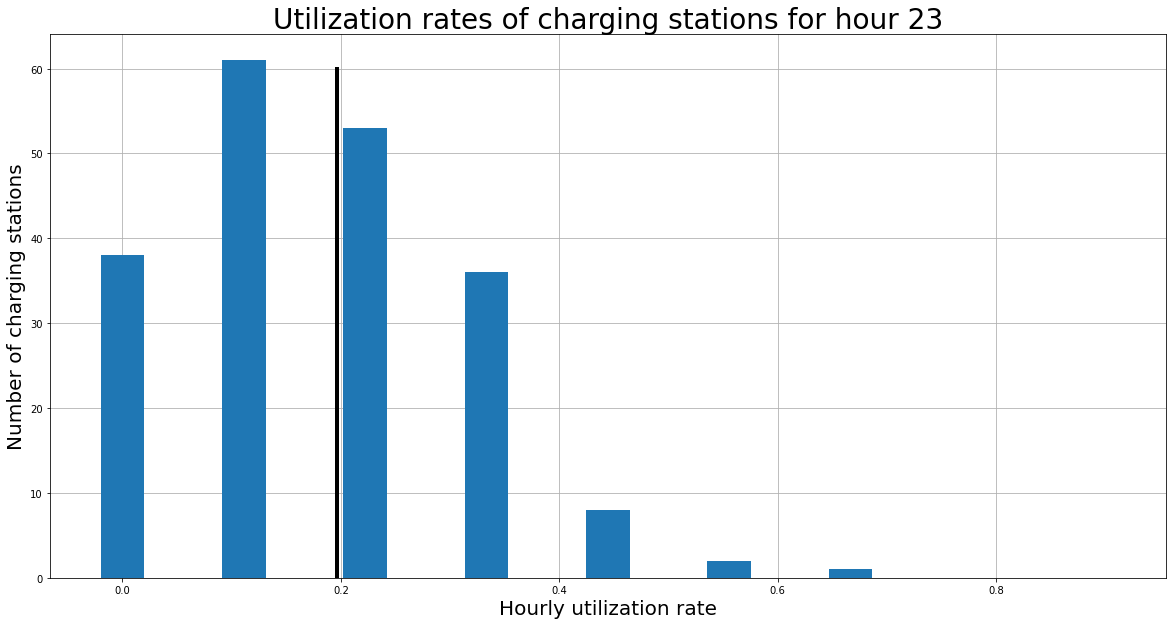

In [268]:
for h in hours:
    counts, bins = np.histogram(df_chargingStations['utilizationRateAt'+str(h)].dropna(),bins=np.linspace(0,1,10))
    plotHistogram(counts,bins[:-1],'Utilization rates of charging stations for hour '+str(h),'Hourly utilization rate',
                  'Number of charging stations',width=0.04)
    plt.plot([meanUtilizationRate[h],meanUtilizationRate[h]],[0,60],color='black',linewidth=4)

The distribution of the utilization rates of charging stations at each hour looks like a normal distribution skewed on the right from 3pm to 7pm and otherwise on the left. It means that the utilization rates are around the mean utilization rate of the hour. But there are more cs with higher utilization rates than with lower utilization rates from 3pm to 7pm and the other way around for other hours. It is likely that it is due to the fact that the demand is focused on the city center in the day so the demand for some areas is lower and some cs have lower demand and therefore, lower utilization rate. From 3pm to 7pm, people tend to come back home or go in the city center and the demand is more spread out. As a result, most of the cs can be used.

CONCLUSION: It has to be understood that the average utilization rate is limited by the fact that the utilization rate during the night is quite low. Furthermore, even for high demand hours, the demand is concentrated in some areas at specific time so some cs have less demand at some hours and their utilization rate is lower. Finally, the supply cannot be fully used as it assumed that people don't queue. So some plugs can remain unused for a while after a car quit if no car come. Very high utilization rates are obtained at 5pm as the demand is already high before and a peak is observed at 5pm. The utilization rates are lower at 7am as there is a peak of demand at 7am but the demand is quite low before it.

# Check that the selected cs is the right one 

In [83]:
#CAREFUL: This check has to be done with probas and df sorted in the same order!! 
#(with the random proba falling in between the cum sum of the cs before and the selected one)
checks=[]

#Reset the index of probas and df
probas=probas.reset_index()
df=df.reset_index()

#Check that the random probas fall in the cum sum of the probas for the selected cs and the one before
for csNumero in range(1,len(df_chargingStations)+1):
    #Keep the trips that are assigned to the charging station 
    index=df[df.selectedCS==csNumero].index
    
    #Check that the right charging station is selected
    if csNumero==1:
        checks.append((probas.loc[index,'probaToGetServedFromCS1']<df.loc[index,'probaToGetServedFromCS'+str(csNumero)]).sum()==len(index))
        
    else:
        checks.append(((probas.loc[index,'probaToGetServedFromCS1']<df.loc[index,'probaToGetServedFromCS'+str(csNumero)])&\
            (probas.loc[index,'probaToGetServedFromCS1']>df.loc[index,'probaToGetServedFromCS'+str(csNumero-1)])).sum()==len(index))
        
print("The charging stations are all assigned correctly:",all(checks))


The charging stations are all assigned correctly: True
